<h2>Store 3266 OGP Associate Metric Analysis 12/20/2024 - 3/28/2025</h2>
<p>Saturday is set as start of a new week</p>
<p>Accounts for old style format from Report 3.0 and new style from new dashboard</p>

In [9]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install xgboost
!pip install lightgbm

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import seaborn as sns
from datetime import datetime, timedelta, date 
import glob
import os
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb

%matplotlib inline
print(f"Is CUDA available? {torch.cuda.is_available()}")

# Check if MPS is available
print("Is MPS available?", torch.backends.mps.is_available())

# Check if MPS is built into your PyTorch installation
print("Is MPS built?", torch.backends.mps.is_built())

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)
#prevents text wrapping from output
pd.set_option('display.width', 1000)

Is CUDA available? False
Is MPS available? True
Is MPS built? True
mps


In [11]:
print(xgb.__version__)  # Ensure it shows the version with GPU support

from xgboost import XGBRegressor
model = XGBRegressor(tree_method="gpu_hist")
print(model.get_params())  # Check if tree_method is set to gpu_hist


2.1.3
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


In [12]:
file = "Data/ByAssociateView_12-20-2024_1-19-2025.csv"
file2 = "Data/ByAssociateView_1-20-2025_1-22-2025.csv"
files = [file, file2]
'''with open(file, "rb") as file:
        result = chardet.detect(file_name.read(10000))
        print(f"File: {file_name}")
        print(f"Detected Encoding: {result['encoding']}, Confidence: {result['confidence']}\n")'''
#df = pd.read_csv(file, encoding="utf-16", sep="\t", engine="python")
#df2 = pd.read_csv(file2, encoding="utf-16", sep="\t", engine="python")

test = False #flag for text files to csv 
delim_same = False #flag for same delimiter across files
# Specify the directory where your CSV files are located
csv_dir = "Data/"  # Update this to your folder path
if test == True:
    csv_dir = "Data/TestTextInput/"  # Update this to your folder path
# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_dir, "ByAssociateView_*.csv"))
# Create an empty list to store DataFrames
dataframes = []
# Loop through each file, read it into a DataFrame, and append it to the list
# Process each file
for file_path in csv_files:
    print(f"File being processed: {file_path}") 
    # Detect encoding
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read(10000))   
    encoding = result['encoding']
    print(f"Detected Encoding: {encoding}, Confidence: {result['confidence']}\n")   
    # Read the file into a DataFrame
    if test == True and delim_same == False:
        print("test == True and delim_same == False")
        try:
            df = pd.read_csv(file_path, encoding=encoding, engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    if test == True and delim_same == True:
        print("test == True and delim_same == True")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    else:
        print("test == False")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

if len(dataframes) > 0:
    dataframes[0].head()
    # Combine the DataFrames row-wise
    combined_df = pd.concat(dataframes, ignore_index=True)
    #print(combined_df)
    print(f'df shape: {df.shape}\ncombined_df shape: {combined_df.shape}')
    df = combined_df
    if 'Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate' in df.columns:
        df = df.drop('Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate', axis=1)
    
    if "Associate ID" in df.columns:
        df = df.sort_values(by=["Associate ID", "Day of Pick Date"], ascending=[True,False])
    elif "Associate" in df.columns:
        df = df.sort_values(by=["Associate", "Day of Pick Date"], ascending=[True,False])
    else:
        print("No 'Associate ID' or 'Associate' column found for sorting.")
    #df.drop_duplicates(subset=["Associate ID", "Day of Pick Date"], keep='first', inplace=True)
    df.reset_index(drop=True)
    print(df.columns.unique())
    print(df.shape)
    df_unique = df.drop_duplicates()
    print(df_unique.shape)
    df = df_unique
else:
    print("No DataFrames to combine.")



File being processed: Data/ByAssociateView_3-25_3-26-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-1-_TO_3-12-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-4_3-5-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_2-24_2-26-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_4-7_4-11-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-27-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_1-28-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_1-29-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-19-2025.cs

In [13]:
#print(df.shape)
df.head(25)

,Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,...,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate ID
378,3266.0,NaN,Total,94.20%,NaN,NaN,72.0,14.51,"1,013",31.0,...,0.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,"1,097",Total
403,3266.0,NaN,Total,96.36%,NaN,NaN,56.0,17.68,956,26.0,...,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,"1,002",Total
473,3266.0,NaN,Total,94.11%,NaN,NaN,63.0,43.39,"2,637",102.0,...,8.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN,"2,802",Total
802,3266.0,NaN,Total,93.50%,NaN,NaN,50.0,21.00,"1,032",28.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"1,111",Total
987,3266.0,NaN,Total,96.57%,NaN,NaN,74.0,21.22,"1,535",31.0,...,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,"1,580",Total
1097,3266.0,NaN,Total,96.10%,NaN,NaN,57.0,24.28,"1,356",32.0,...,1.0,7.0,3.0,NaN,NaN,NaN,NaN,NaN,"1,433",Total
1729,3266.0,NaN,Total,90.66%,NaN,NaN,61.0,21.92,"1,254",74.0,...,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,"1,386",Total
1840,3266.0,NaN,Total,95.35%,NaN,NaN,61.0,65.25,"3,907",96.0,...,6.0,18.0,6.0,NaN,NaN,NaN,NaN,NaN,"4,092",Total
2171,3266.0,NaN,Total,95.65%,NaN,NaN,59.0,24.14,"1,395",35.0,...,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,"1,464",Total
2202,3266.0,NaN,Total,96.04%,NaN,NaN,56.0,19.92,"1,096",18.0,...,1.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,"1,175",Total


In [14]:
'''df = df.drop(df.columns[15], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[0], axis=1)
#df = df.set_index("Associate ID")'''
df = df.drop(['SFS Pack Hours', 'SFS Packed Qty', 'SFS Pack Rate', 'Store #'], axis=1)

In [15]:
df.head()

,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate ID
378,NaN,Total,94.20%,NaN,NaN,72.0,14.51,"1,013",31.0,NaN,22,12.0,0.0,8.0,4.0,NaN,NaN,"1,097",Total
403,NaN,Total,96.36%,NaN,NaN,56.0,17.68,956,26.0,NaN,15,2.0,1.0,1.0,0.0,NaN,NaN,"1,002",Total
473,NaN,Total,94.11%,NaN,NaN,63.0,43.39,"2,637",102.0,NaN,44,19.0,8.0,4.0,7.0,NaN,NaN,"2,802",Total
802,NaN,Total,93.50%,NaN,NaN,50.0,21.00,"1,032",28.0,NaN,42,0.0,0.0,0.0,0.0,NaN,NaN,"1,111",Total
987,NaN,Total,96.57%,NaN,NaN,74.0,21.22,"1,535",31.0,NaN,7,5.0,2.0,1.0,2.0,NaN,NaN,"1,580",Total


In [16]:

#df = df[df["Associate ID"] != "csp"]
ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica A',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Mathew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chetna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}
if "Associate ID" not in df.columns:
    # If Associate ID is missing but Associate Name exists, fill ID using the reverse of names_to_ids
    df['Associate ID'] = None

ids_to_names = {v.upper(): k for k, v in names_to_ids.items()}  # Reverse dictionary
ids_to_names["csp"] = "csp"
ids_to_names["Total"] = "Total"
print(ids_to_names)
# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)
#df = df[~df["Associate ID"].isin(ids_to_drop)]
df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")
#df = df.reset_index()
df['Associate ID'].unique()
df = df.drop(['Associate'], axis=1)

if "Associate ID" in df.columns:
    print("True")
    df = df[~df["Associate ID"].isin(ids_to_drop)]
    df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")

df["Associate ID"] = df["Associate ID"].replace({None: pd.NA})
df = df.dropna(subset=["Associate ID"])

col_to_move = "Associate ID"
col_vals = df["Associate ID"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(0, col_to_move, col_vals)

col_to_move = "Associate Name"
col_vals = df["Associate Name"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(1, col_to_move, col_vals)
print(df['Associate Name'].unique())


{'ANGELA BAIORI': 'a0b0ad9', 'AURORA COMPRES': 'a0c02mv', 'ANDREA FIGUEROA': 'a0f0grp', 'ANDREW PLAZA': 'a0p0fc6', 'ARPANA SILUMALA': 'a0s1jgx', 'CIANA RIPA': 'c0r0k4h', 'DANIEL RUSSO': 'd0r0khi', 'ERIK ENRIQUEZ': 'e0e04sh', 'ESTHER MARTINEZ': 'e0m0abw', 'ERICKA SUIN': 'e0s0frj', 'HEENA PATEL': 'h0p01q8', 'JESSICA A': 'j0a0f5h', 'JESICA PUGO': 'j0p0vpl', 'JULIA SIGUENCIA': 'jrsigue', 'LUCILLE LAWSON': 'l0l064x', 'MAGDALENA GRIJALVA': 'm0g065v', 'MIROLLA SAID': 'm0s0q17', 'MARIA SANCHEZ': 'mgs004k', 'NATHANIEL VENTURA': 'n0v0359', 'NOELIA VENTURA DE SANTANA': 'n0v03hh', 'NICOLE WEAVER': 'n0w044f', 'SHAMIMA HAQUE MITU': 's0m0uve', 'SIDDH PANDYA': 's0p0hsd', 'SHARON TUFANO': 'stufano', 'TIERRA BROWN': 't0b0hm5', 'GABRIEL NYDICK': 'g0n018d', 'DANIELLE CASIANO': 'd0c0as3', 'AMMAD IQBAL': 'azi0001', 'MILTON TORRES': 'm0t03tx', 'PABLO CHAVEZ': 'p0c096p', 'IVET SAQUICELA': 'i0s01rf', 'SHUBHADA MENGLE': 's0m11qg', 'MATHEW BEDNARCZUK': 'mdb00c8', 'VICTORIA MORALES': 'v0m07r6', 'JOHN MCKENNA': 'j

In [17]:
'''ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
# Dictionary mapping IDs to Names
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica A',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Mathew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chatna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}

# Convert all dictionary keys to lowercase (for IDs) and uppercase (for Names)
names_to_ids = {k.lower().strip(): v.upper().strip() for k, v in names_to_ids.items()}
ids_to_names = {v.upper().strip(): k.lower().strip() for k, v in names_to_ids.items()}

# Ensure "Associate ID" and "Associate Name" columns exist
if "Associate ID" not in df.columns:
    df["Associate ID"] = None
if "Associate Name" not in df.columns:
    df["Associate Name"] = None

# Convert columns to string, strip spaces, and normalize case
df["Associate ID"] = df["Associate ID"].astype(str).str.lower().str.strip().replace("none", None)
df["Associate Name"] = df["Associate Name"].astype(str).str.upper().str.strip().replace("NONE", None)

# Preserve original columns
original_columns = df.columns.tolist()

# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate Name"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)

# Fill missing Associate Name using Associate ID
df["Associate Name"] = df.apply(
    lambda row: names_to_ids.get(row["Associate ID"], row["Associate Name"]) 
    if pd.isna(row["Associate Name"]) or row["Associate Name"] is None else row["Associate Name"],
    axis=1
)

# Ensure we are not accidentally dropping other columns
df = df[original_columns]

# Debugging: Print final columns to verify
print("Final columns in DataFrame:", df.columns.tolist())

# Print a preview of the DataFrame to check
print(df.head())
'''



'ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]\nids_to_drop = ["csp", "Total", "nsm"]\n#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]\n# Dictionary mapping IDs to Names\nnames_to_ids = {\n    \'a0b0ad9\': \'Angela Baiori\', \'a0c02mv\': \'Aurora Compres\', \'a0f0grp\': \'Andrea Figueroa\',\n    \'a0p0fc6\': \'Andrew Plaza\', \'a0s1jgx\': \'Arpana Silumala\', \'c0r0k4h\': \'Ciana Ripa\',\n    \'d0r0khi\': \'Daniel Russo\', \'e0e04sh\': \'Erik Enriquez\', \'e0m0abw\': \'Esther Martinez\',\n    \'e0s0frj\': \'Ericka Suin\', \'h0p01q8\': \'Heena Patel\', \'j0a0f5h\': \'Jessica A\',\n    \'j0p0vpl\': \'Jesica Pugo\', \'jrsigue\': \'Julia Siguencia\', \'l0l064x\': \'Lucille Lawson\',\n    \'m0g065v\': \'Magdalena Grijalva\', \'m0s0q17\': \'Mirolla 

In [18]:
df.head(75)
df.loc[df['Associate Name'] == 'NA', :]

,Associate ID,Associate Name,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick


In [19]:
df = df.loc[df["Day of Pick Date"] != "Total"]
df.head(10)

,Associate ID,Associate Name,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick
431,a0b0ad9,Angela Baiori,2/5/25,97.01%,NaN,NaN,60.0,3.86,227,4.0,NaN,3,0.0,0.0,0.0,0.0,NaN,NaN,233
3043,a0b0ad9,Angela Baiori,2/3/25,NaN,NaN,NaN,NaN,0.00,0,0.0,NaN,0,1.0,0.0,2.0,0.0,NaN,NaN,0
3066,a0b0ad9,Angela Baiori,2/2/25,97.03%,NaN,NaN,59.0,4.36,254,2.0,NaN,10,0.0,0.0,0.0,0.0,NaN,NaN,268
2401,a0b0ad9,Angela Baiori,12/29/24,92.92%,NaN,NaN,42.0,4.88,199,6.0,NaN,4,0.0,0.0,0.0,0.0,NaN,NaN,214
2402,a0b0ad9,Angela Baiori,12/27/24,100.00%,NaN,NaN,79.0,0.60,47,0.0,NaN,0,0.0,0.0,0.0,0.0,NaN,NaN,47
2403,a0b0ad9,Angela Baiori,12/26/24,92.66%,NaN,NaN,51.0,4.18,212,3.0,NaN,5,2.0,0.0,0.0,2.0,NaN,NaN,223
2404,a0b0ad9,Angela Baiori,12/24/24,95.83%,NaN,NaN,38.0,3.76,141,1.0,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,146
2405,a0b0ad9,Angela Baiori,12/22/24,98.53%,NaN,NaN,29.0,4.67,134,3.0,NaN,2,0.0,0.0,0.0,0.0,NaN,NaN,138
2395,a0b0ad9,Angela Baiori,1/9/25,97.25%,NaN,NaN,47.0,3.80,177,2.0,NaN,2,8.0,0.0,0.0,8.0,NaN,NaN,179
2396,a0b0ad9,Angela Baiori,1/8/25,97.50%,NaN,NaN,48.0,1.64,78,0.0,NaN,5,0.0,0.0,0.0,0.0,NaN,NaN,85


In [20]:
# Replace NaN values with 0
#df['Qty Req to Pick'] = df['Qty Req to Pick'].fillna(0)
# Ensure both columns are cleaned and converted to numeric
df['Qty Req to Pick'] = df['Qty Req to Pick'].replace(',', '', regex=True).fillna(0).astype(int)
df['FTP Expected'] = df['FTP Expected'].replace(',', '', regex=True).fillna(0).astype(int)

# Replace 0 values in 'Qty Req to Pick' with corresponding values from 'FTP Expected'
#df.loc[df['Qty Req to Pick'] == 0, 'Qty Req to Pick'] = df.loc[df['Qty Req to Pick'] == 0, 'FTP Expected']
df['Qty Req to Pick'] = df['Qty Req to Pick'].mask(df['Qty Req to Pick'] == 0, df['FTP Expected'])
df['FTP Expected'] = df['FTP Expected'].mask(df['FTP Expected'] == 0, df['Qty Req to Pick'])
df = df.loc[:,:].fillna(0)

# Ensure 'Qty Req to Pick' is numeric
df['Qty Req to Pick'] = pd.to_numeric(df['Qty Req to Pick'], errors='coerce')
df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)
df = df.dropna()
df.head()

,Associate ID,Associate Name,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick
431,a0b0ad9,Angela Baiori,2/5/25,97.01,233,0,60.0,3.86,227,4.0,0.0,3,0.0,0.0,0.0,0.0,0,0,233
3066,a0b0ad9,Angela Baiori,2/2/25,97.03,268,0,59.0,4.36,254,2.0,0.0,10,0.0,0.0,0.0,0.0,0,0,268
2401,a0b0ad9,Angela Baiori,12/29/24,92.92,214,0,42.0,4.88,199,6.0,0.0,4,0.0,0.0,0.0,0.0,0,0,214
2402,a0b0ad9,Angela Baiori,12/27/24,100.00,47,0,79.0,0.60,47,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,47
2403,a0b0ad9,Angela Baiori,12/26/24,92.66,223,0,51.0,4.18,212,3.0,0.0,5,2.0,0.0,0.0,2.0,0,0,223


In [21]:
#df.loc["a0b0ad9", :]
#df = df.loc[df["Day of Pick Date"] != "Total"]
df.loc[df["Associate ID"] == "a0b0ad9" ,:]

,Associate ID,Associate Name,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick
431,a0b0ad9,Angela Baiori,2/5/25,97.01,233,0,60.0,3.86,227,4.0,0.0,3,0.0,0.0,0.0,0.0,0,0,233
3066,a0b0ad9,Angela Baiori,2/2/25,97.03,268,0,59.0,4.36,254,2.0,0.0,10,0.0,0.0,0.0,0.0,0,0,268
2401,a0b0ad9,Angela Baiori,12/29/24,92.92,214,0,42.0,4.88,199,6.0,0.0,4,0.0,0.0,0.0,0.0,0,0,214
2402,a0b0ad9,Angela Baiori,12/27/24,100.00,47,0,79.0,0.60,47,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,47
2403,a0b0ad9,Angela Baiori,12/26/24,92.66,223,0,51.0,4.18,212,3.0,0.0,5,2.0,0.0,0.0,2.0,0,0,223
2404,a0b0ad9,Angela Baiori,12/24/24,95.83,146,0,38.0,3.76,141,1.0,0.0,1,0.0,0.0,0.0,0.0,0,0,146
2405,a0b0ad9,Angela Baiori,12/22/24,98.53,138,0,29.0,4.67,134,3.0,0.0,2,0.0,0.0,0.0,0.0,0,0,138
2395,a0b0ad9,Angela Baiori,1/9/25,97.25,179,0,47.0,3.80,177,2.0,0.0,2,8.0,0.0,0.0,8.0,0,0,179
2396,a0b0ad9,Angela Baiori,1/8/25,97.50,85,0,48.0,1.64,78,0.0,0.0,5,0.0,0.0,0.0,0.0,0,0,85
2398,a0b0ad9,Angela Baiori,1/5/25,98.89,273,0,64.0,4.28,269,4.0,0.0,0,0.0,0.0,0.0,0.0,0,0,273


In [22]:
df.loc[df['Associate ID'] == "rsw000v" , :]
#df.loc[df['Associate Name'] == "Victoria Morales", :]

,Associate ID,Associate Name,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick
2088,rsw000v,Rasheed Wallace,4/4/25,84.62,39,33,53.7,0.62,33,0.0,0.0,6,0.0,0.0,0.0,0.0,0,0,39
153,rsw000v,Rasheed Wallace,3/5/25,83.04,0,0,110.0,0.97,94,13.0,0.0,5,2.0,1.0,1.0,0.0,112,93,0
923,rsw000v,Rasheed Wallace,3/20/25,100.00,2,2,300.0,0.01,2,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,2
2268,rsw000v,Rasheed Wallace,2/11/25,91.18,34,0,63.0,0.50,31,1.0,0.0,0,0.0,0.0,0.0,0.0,0,0,34


In [23]:
# Convert "Day of Pick Date" to datetime
df["Day of Pick Date"] = pd.to_datetime(df["Day of Pick Date"], format="%m/%d/%y")

# Adjust dates to align with Saturday as the start of the week
df["Custom Week Start"] = df["Day of Pick Date"] - pd.to_timedelta((df["Day of Pick Date"].dt.dayofweek + 2) % 7, unit="d")

# Calculate the end of the week (Friday)
df["Custom Week End"] = df["Custom Week Start"] + pd.Timedelta(days=6)

# Combine start and end dates into a single "Week" column as a range
df['Week'] = df["Custom Week Start"].dt.strftime('%Y-%m-%d') + " to " + df["Custom Week End"].dt.strftime('%Y-%m-%d')

oldest_pick_date = df["Day of Pick Date"].min()
last_pick_date = df["Day of Pick Date"].max()
oldest_pick_date = pd.to_datetime(oldest_pick_date).date()
last_pick_date = pd.to_datetime(last_pick_date).date()
print(f"start date: {oldest_pick_date}")
print(f"end date: {last_pick_date}")
def combine_data_to_csv():
    # Create the directory
    try:
        os.mkdir("Data/Combined/")
        print(f"Directory '{"Data/Combined/"}' created successfully.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False)
    except FileExistsError:
        print(f"Directory '{"Data/Comnined/"}' already exists.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False)
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
#combine_data_to_csv()
#df.loc[df["Associate ID"] == "a0b0ad9", :]

start date: 2024-12-20
end date: 2025-04-12


In [24]:
print(df.info())
# Group by Associate ID and Week and apply aggregations
# Convert problematic columns to numeric, coercing errors to NaN
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')
df['Nil Pick Qty'] = pd.to_numeric(df['Nil Pick Qty'], errors='coerce')

# Check for NaN values introduced after conversion
print("Null values after conversion:")
print(df[['Picked As Req Qty', 'Nil Pick Qty']].isna().sum())
weekly_data = df.groupby(['Week', 'Associate ID', "Associate Name"]).agg(
    total_qty_req_to_pick=('Qty Req to Pick', 'sum'),  # Ensure correct column name here
    total_picked_qty=('Picked As Req Qty', 'sum'),  # Added for reference
    avg_pick_rate=('Pick Rate', 'mean'),
    total_substitution_qty=('Substitution Qty', 'sum'),
    total_nil_pick_qty=('Nil Pick Qty', 'sum'),
    total_exception_qty_req=('Exception Qty Req to Pick', 'sum'),
    total_exception_picked_qty=('Exception Picked As Req Qty', 'sum'),
    total_exception_substitution_qty=('Exception Substitution Qty', 'sum'),
    total_exception_nil_pick_qty=('Exception Nil Pick Qty', 'sum')
).reset_index()
weekly_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1379 entries, 431 to 488
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Associate ID                 1379 non-null   object        
 1   Associate Name               1379 non-null   object        
 2   Day of Pick Date             1379 non-null   datetime64[ns]
 3   FTPR                         1379 non-null   float64       
 4   FTP Expected                 1379 non-null   int64         
 5   FTP Actual                   1379 non-null   object        
 6   Pick Rate                    1379 non-null   float64       
 7   Pick Hours                   1379 non-null   float64       
 8   Picked As Req Qty            1379 non-null   object        
 9   Substitution Qty             1379 non-null   float64       
 10  Ovrd Qty                     1379 non-null   float64       
 11  Nil Pick Qty                 1379 non-null   ob

,Week,Associate ID,Associate Name,total_qty_req_to_pick,total_picked_qty,avg_pick_rate,total_substitution_qty,total_nil_pick_qty,total_exception_qty_req,total_exception_picked_qty,total_exception_substitution_qty,total_exception_nil_pick_qty
0,2024-12-14 to 2024-12-20,a0f0grp,Andrea Figueroa,147,144,55.0,1.0,2,1.0,1.0,0.0,0.0
1,2024-12-14 to 2024-12-20,a0p0fc6,Andrew Plaza,50,49,36.0,0.0,0,0.0,0.0,0.0,0.0
2,2024-12-14 to 2024-12-20,c0c116s,Christina Cucitro,4,4,46.0,0.0,0,0.0,0.0,0.0,0.0
3,2024-12-14 to 2024-12-20,d0r0khi,Daniel Russo,34,32,81.0,2.0,0,0.0,0.0,0.0,0.0
4,2024-12-14 to 2024-12-20,e0e04sh,Erik Enriquez,5,5,16.0,0.0,0,0.0,0.0,0.0,0.0


In [25]:
weekly_data.loc[weekly_data['Associate ID'] == 'a0p0fc6']

,Week,Associate ID,Associate Name,total_qty_req_to_pick,total_picked_qty,avg_pick_rate,total_substitution_qty,total_nil_pick_qty,total_exception_qty_req,total_exception_picked_qty,total_exception_substitution_qty,total_exception_nil_pick_qty
1,2024-12-14 to 2024-12-20,a0p0fc6,Andrew Plaza,50,49,36.000000,0.0,0,0.0,0.0,0.0,0.0
18,2024-12-21 to 2024-12-27,a0p0fc6,Andrew Plaza,217,194,33.750000,19.0,1,0.0,0.0,0.0,0.0
47,2024-12-28 to 2025-01-03,a0p0fc6,Andrew Plaza,171,168,48.333333,0.0,1,1.0,0.0,1.0,0.0
77,2025-01-04 to 2025-01-10,a0p0fc6,Andrew Plaza,131,130,45.000000,2.0,0,0.0,0.0,0.0,0.0
104,2025-01-11 to 2025-01-17,a0p0fc6,Andrew Plaza,39,37,43.000000,1.0,1,0.0,0.0,0.0,0.0
131,2025-01-18 to 2025-01-24,a0p0fc6,Andrew Plaza,130,120,38.000000,0.0,6,1.0,0.0,0.0,1.0
157,2025-01-25 to 2025-01-31,a0p0fc6,Andrew Plaza,42,42,51.000000,0.0,0,0.0,0.0,0.0,0.0
209,2025-02-08 to 2025-02-14,a0p0fc6,Andrew Plaza,64,64,44.000000,0.0,0,0.0,0.0,0.0,0.0
237,2025-02-15 to 2025-02-21,a0p0fc6,Andrew Plaza,76,69,55.000000,0.0,1,2.0,0.0,0.0,2.0
265,2025-02-22 to 2025-02-28,a0p0fc6,Andrew Plaza,64,80,66.000000,0.0,0,0.0,0.0,0.0,0.0


In [26]:
df.loc[df['Associate ID'] == 'a0p0fc6']

,Associate ID,Associate Name,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,...,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Custom Week Start,Custom Week End,Week
2439,a0p0fc6,Andrew Plaza,2024-12-31,95.59,66,0,65.0,1.00,65,0.0,...,0.0,0.0,0.0,0.0,0,0,66,2024-12-28,2025-01-03,2024-12-28 to 2025-01-03
2440,a0p0fc6,Andrew Plaza,2024-12-28,96.88,32,0,50.0,0.64,32,0.0,...,0.0,0.0,0.0,0.0,0,0,32,2024-12-28,2025-01-03,2024-12-28 to 2025-01-03
2441,a0p0fc6,Andrew Plaza,2024-12-27,96.23,53,0,38.0,1.38,51,2.0,...,0.0,0.0,0.0,0.0,0,0,53,2024-12-21,2024-12-27,2024-12-21 to 2024-12-27
2442,a0p0fc6,Andrew Plaza,2024-12-26,75.68,34,0,33.0,1.03,31,3.0,...,0.0,0.0,0.0,0.0,0,0,34,2024-12-21,2024-12-27,2024-12-21 to 2024-12-27
2443,a0p0fc6,Andrew Plaza,2024-12-22,80.00,90,0,38.0,2.37,75,14.0,...,0.0,0.0,0.0,0.0,0,0,90,2024-12-21,2024-12-27,2024-12-21 to 2024-12-27
2444,a0p0fc6,Andrew Plaza,2024-12-21,97.37,40,0,26.0,1.40,37,0.0,...,0.0,0.0,0.0,0.0,0,0,40,2024-12-21,2024-12-27,2024-12-21 to 2024-12-27
2445,a0p0fc6,Andrew Plaza,2024-12-20,94.00,50,0,36.0,1.34,49,0.0,...,0.0,0.0,0.0,0.0,0,0,50,2024-12-14,2024-12-20,2024-12-14 to 2024-12-20
2435,a0p0fc6,Andrew Plaza,2025-01-07,95.83,48,0,44.0,1.09,46,2.0,...,0.0,0.0,0.0,0.0,0,0,48,2025-01-04,2025-01-10,2025-01-04 to 2025-01-10
2436,a0p0fc6,Andrew Plaza,2025-01-05,100.00,64,0,51.0,1.25,64,0.0,...,0.0,0.0,0.0,0.0,0,0,64,2025-01-04,2025-01-10,2025-01-04 to 2025-01-10
2437,a0p0fc6,Andrew Plaza,2025-01-04,95.00,19,0,40.0,0.50,20,0.0,...,0.0,0.0,0.0,0.0,0,0,19,2025-01-04,2025-01-10,2025-01-04 to 2025-01-10


In [27]:
unique_ids = df["Associate ID"].unique()
unique_ids_list = unique_ids.tolist()
#for a in unique_ids_list:
#    print(a)

In [28]:
#for a in unique_ids_list:
#    print(df.loc[df["Associate ID"] == a, : "Pick Hours"])

In [29]:
#df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)

In [30]:
avdf = df.groupby(["Associate ID", "Associate Name"]).mean(numeric_only=True)

In [31]:
avdf.head()

,,FTPR,FTP Expected,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,Qty Req to Pick
Associate ID,Associate Name,,,,,,,,,,,,,
a0b0ad9,Angela Baiori,96.181404,150.070175,52.800000,3.690877,178.736842,3.210526,0.0,4.421053,0.719298,0.228070,0.087719,0.403509,150.070175
a0c02mv,Aurora Compres,94.189500,65.400000,43.770000,1.777500,73.800000,2.700000,0.0,3.450000,0.500000,0.000000,0.500000,0.000000,65.400000
a0f0grp,Andrea Figueroa,96.410833,112.645833,57.608333,2.113125,113.750000,2.500000,0.0,2.208333,0.354167,0.187500,0.145833,0.020833,112.645833
a0p0fc6,Andrew Plaza,92.642188,48.781250,45.643750,1.253125,53.406250,1.250000,0.0,1.531250,0.625000,0.062500,0.031250,0.531250,48.781250
a0s1jgx,Arpana Silumala,94.861875,132.250000,43.020833,3.388958,142.833333,2.708333,0.0,5.354167,0.250000,0.166667,0.020833,0.062500,132.250000


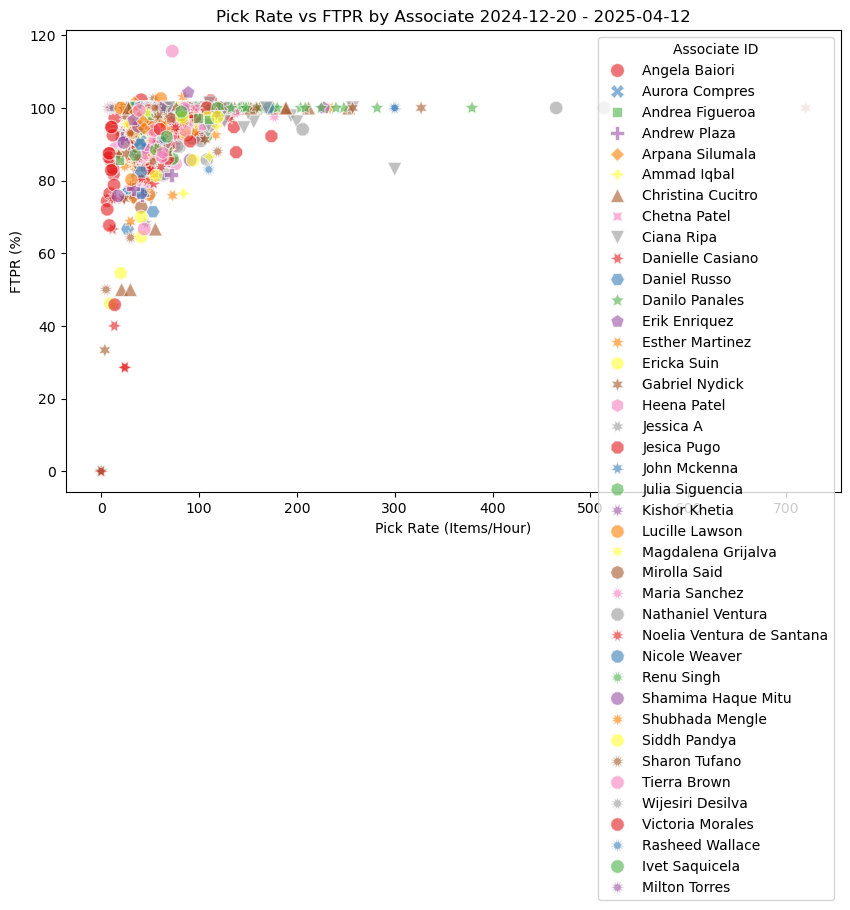

In [32]:
# Scatter plot with Pick Rate vs FTPR
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Pick Rate', y='FTPR', hue='Associate Name', palette='Set1', style='Associate Name', s=100, alpha=0.6)
plt.title(f'Pick Rate vs FTPR by Associate {oldest_pick_date} - {last_pick_date}')
plt.xlabel('Pick Rate (Items/Hour)')
plt.ylabel('FTPR (%)')
plt.legend(title='Associate ID')
plt.show()


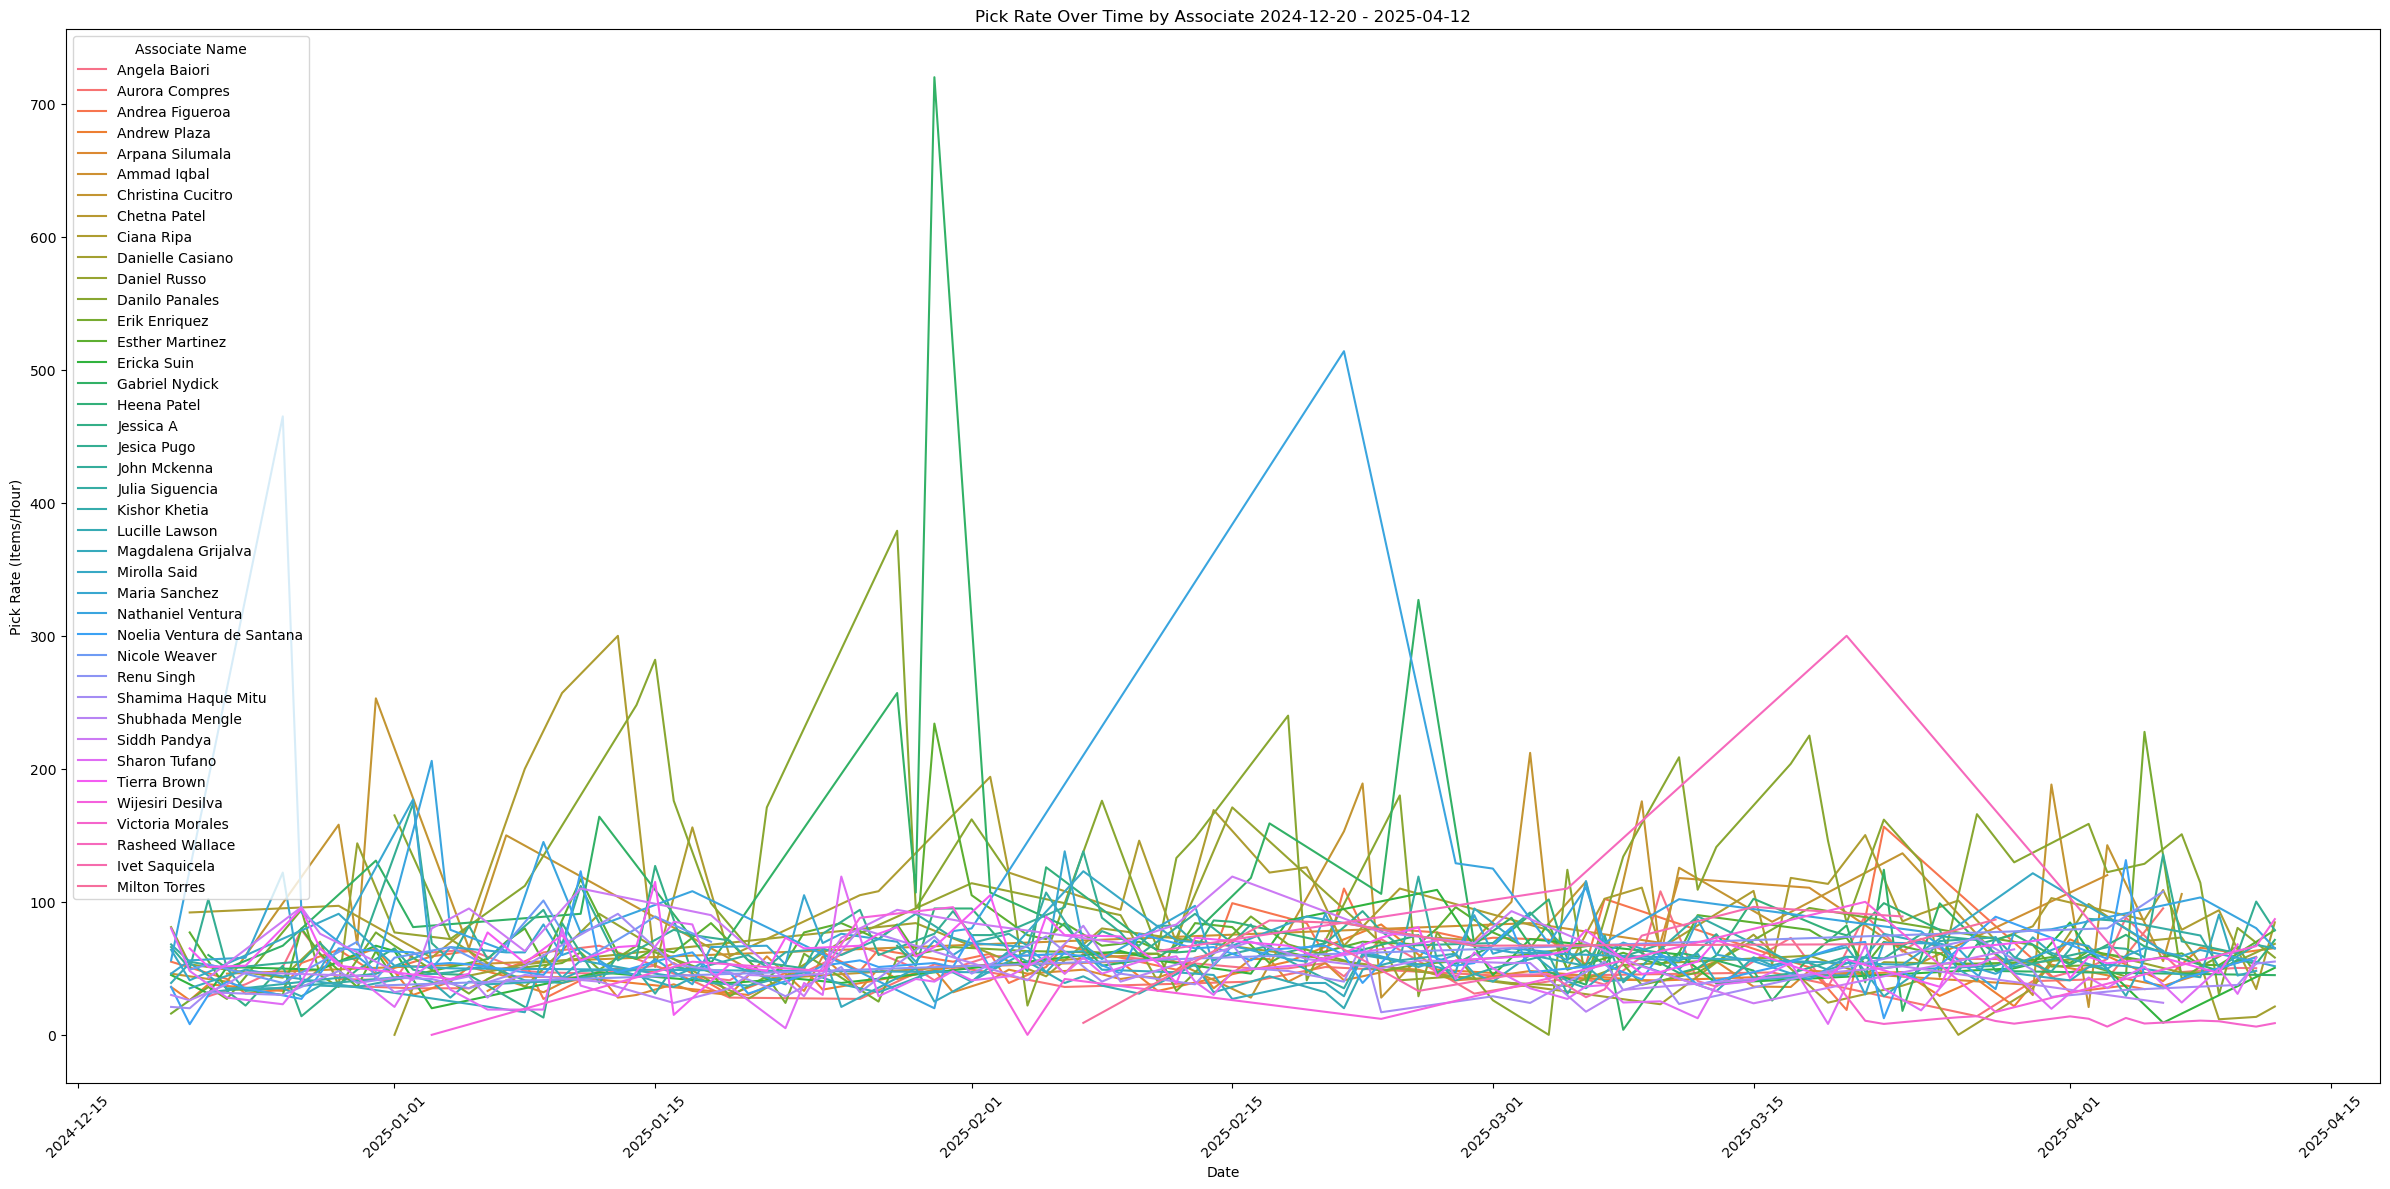

In [33]:
# Convert 'Day of Pick Date' to datetime format for time-based analysis
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], format='%m/%d/%y')

# Line plot of Pick Rate over time for each Associate
plt.figure(figsize=(24, 12))
sns.lineplot(data=df, x='Day of Pick Date', y='Pick Rate', hue='Associate Name', markers=True)
plt.title(f'Pick Rate Over Time by Associate {oldest_pick_date} - {last_pick_date}')
plt.xlabel('Date')
plt.ylabel('Pick Rate (Items/Hour)')
plt.xticks(rotation=45)
plt.legend(title='Associate Name')
plt.tight_layout()
plt.show()


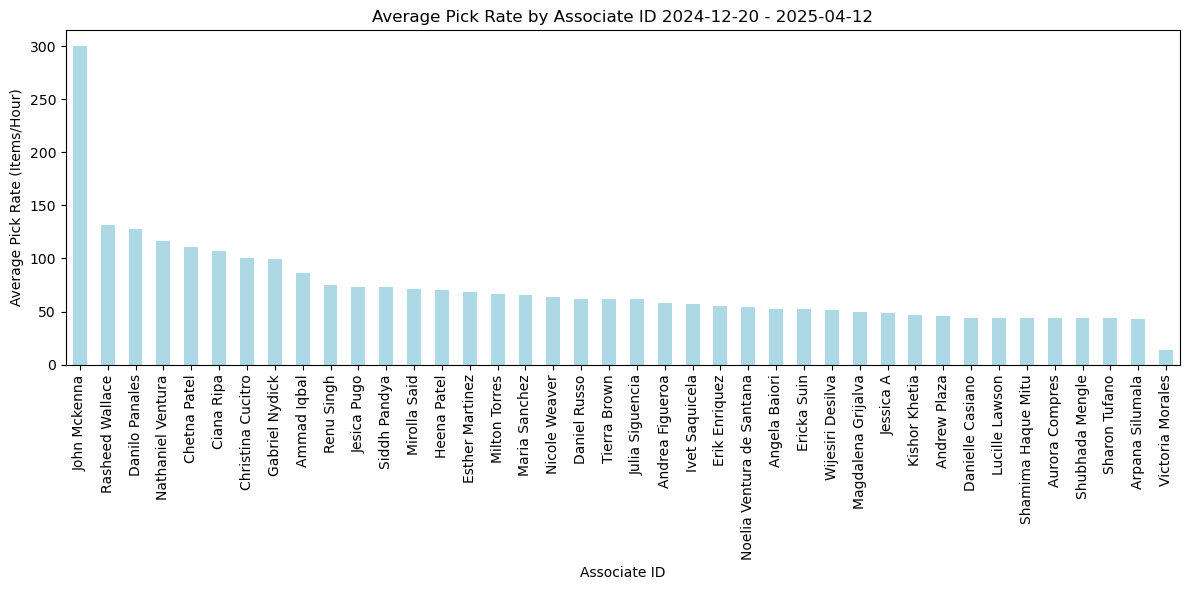

Associate Name
John Mckenna                 300.000000
Rasheed Wallace              131.675000
Danilo Panales               127.822000
Nathaniel Ventura            116.785185
Chetna Patel                 111.000000
Ciana Ripa                   107.056522
Christina Cucitro            100.477419
Gabriel Nydick                99.687500
Ammad Iqbal                   86.014286
Renu Singh                    74.933333
Jesica Pugo                   73.088406
Siddh Pandya                  72.696000
Mirolla Said                  71.028571
Heena Patel                   70.175000
Esther Martinez               68.269014
Milton Torres                 66.816667
Maria Sanchez                 65.424324
Nicole Weaver                 63.384615
Daniel Russo                  62.122857
Tierra Brown                  61.757377
Julia Siguencia               61.596970
Andrea Figueroa               57.608333
Ivet Saquicela                57.555556
Erik Enriquez                 55.666667
Noelia Ventura de Santana

In [34]:
# Grouping by Associate ID and calculating average Pick Rate
avg_pick_rate = df.groupby('Associate Name')['Pick Rate'].mean().sort_values(ascending=False)

# Bar plot for average Pick Rate per Associate ID
plt.figure(figsize=(12, 6))
avg_pick_rate.plot(kind='bar', color='lightblue')
plt.title(f'Average Pick Rate by Associate ID {oldest_pick_date} - {last_pick_date}')
plt.xlabel('Associate ID')
plt.ylabel('Average Pick Rate (Items/Hour)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

avg_pick_rate

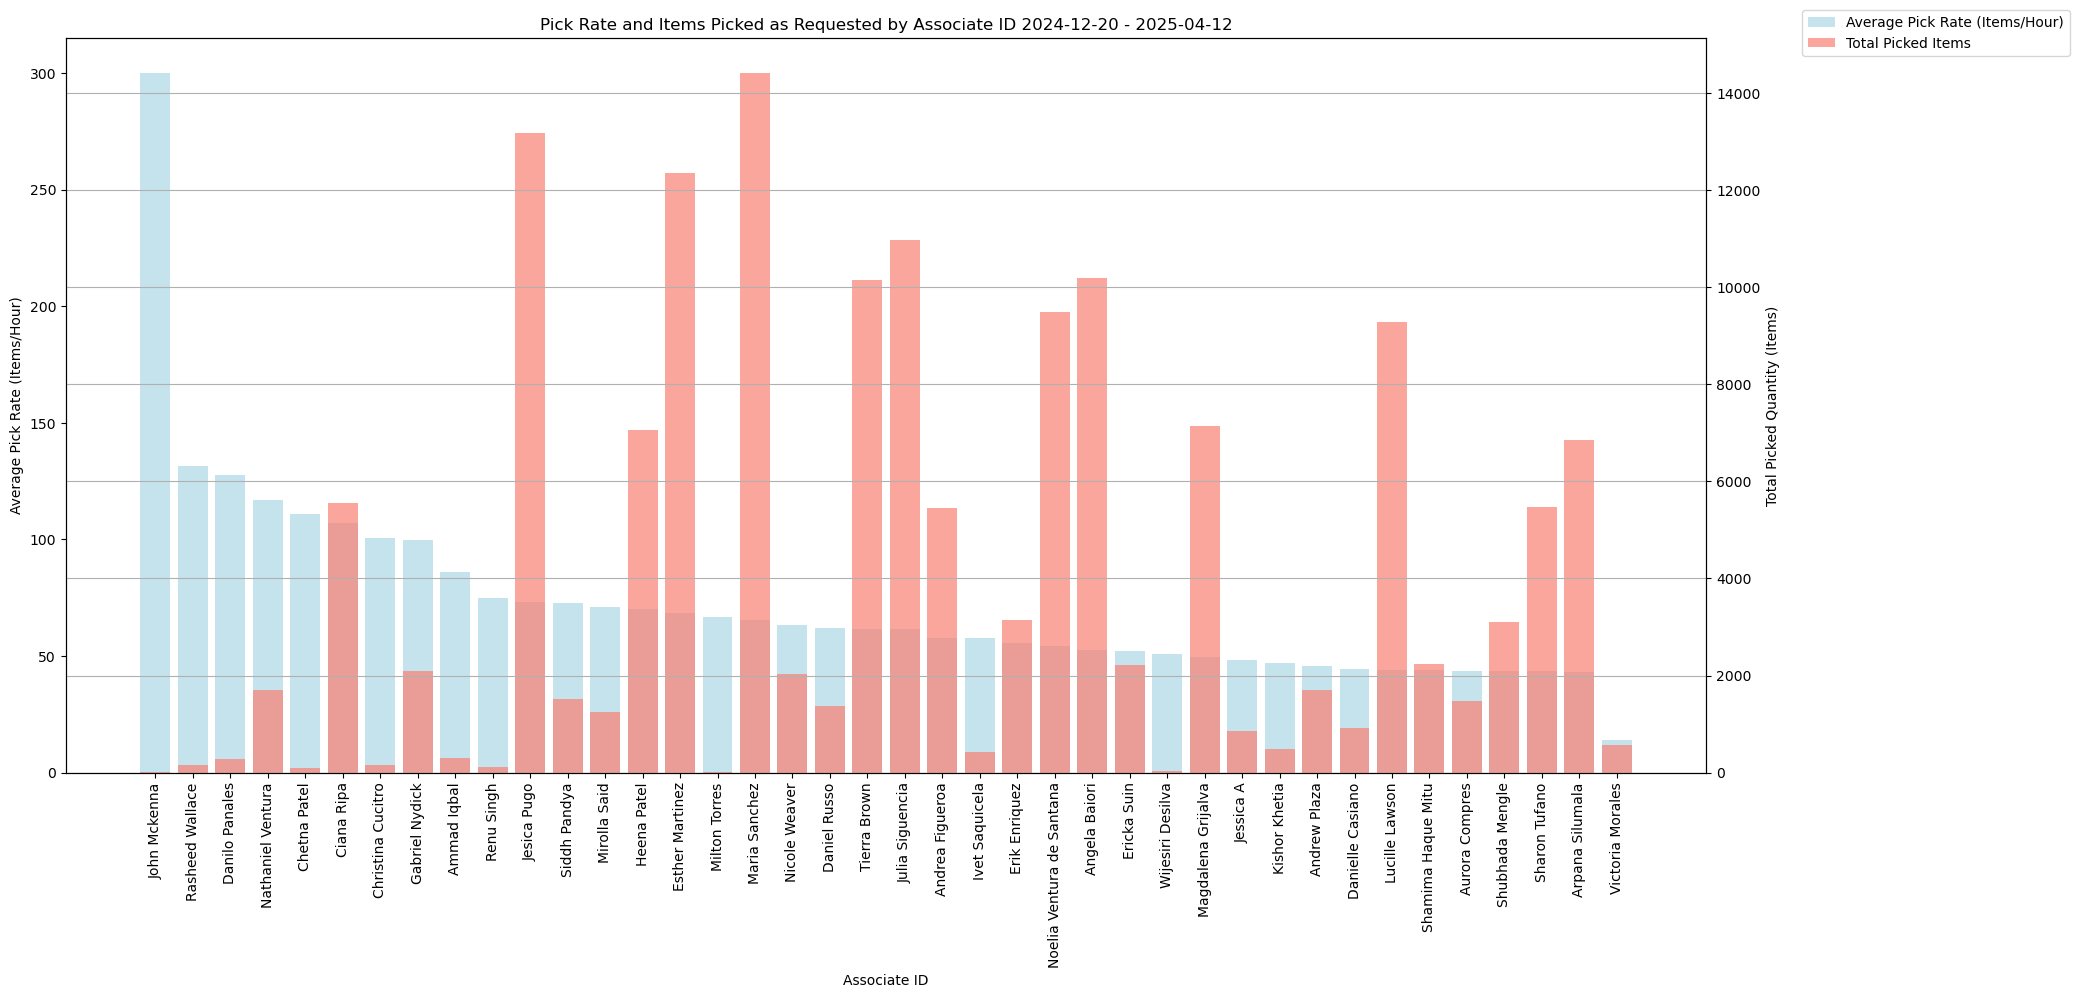

In [35]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_pick_rate = df_clean.groupby('Associate Name')['Pick Rate'].mean().sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate Name')['Picked As Req Qty'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_pick_rate.index, avg_pick_rate, color='lightblue', alpha=0.7, label='Average Pick Rate (Items/Hour)')
ax1.set_xlabel('Associate ID')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Pick Rate and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


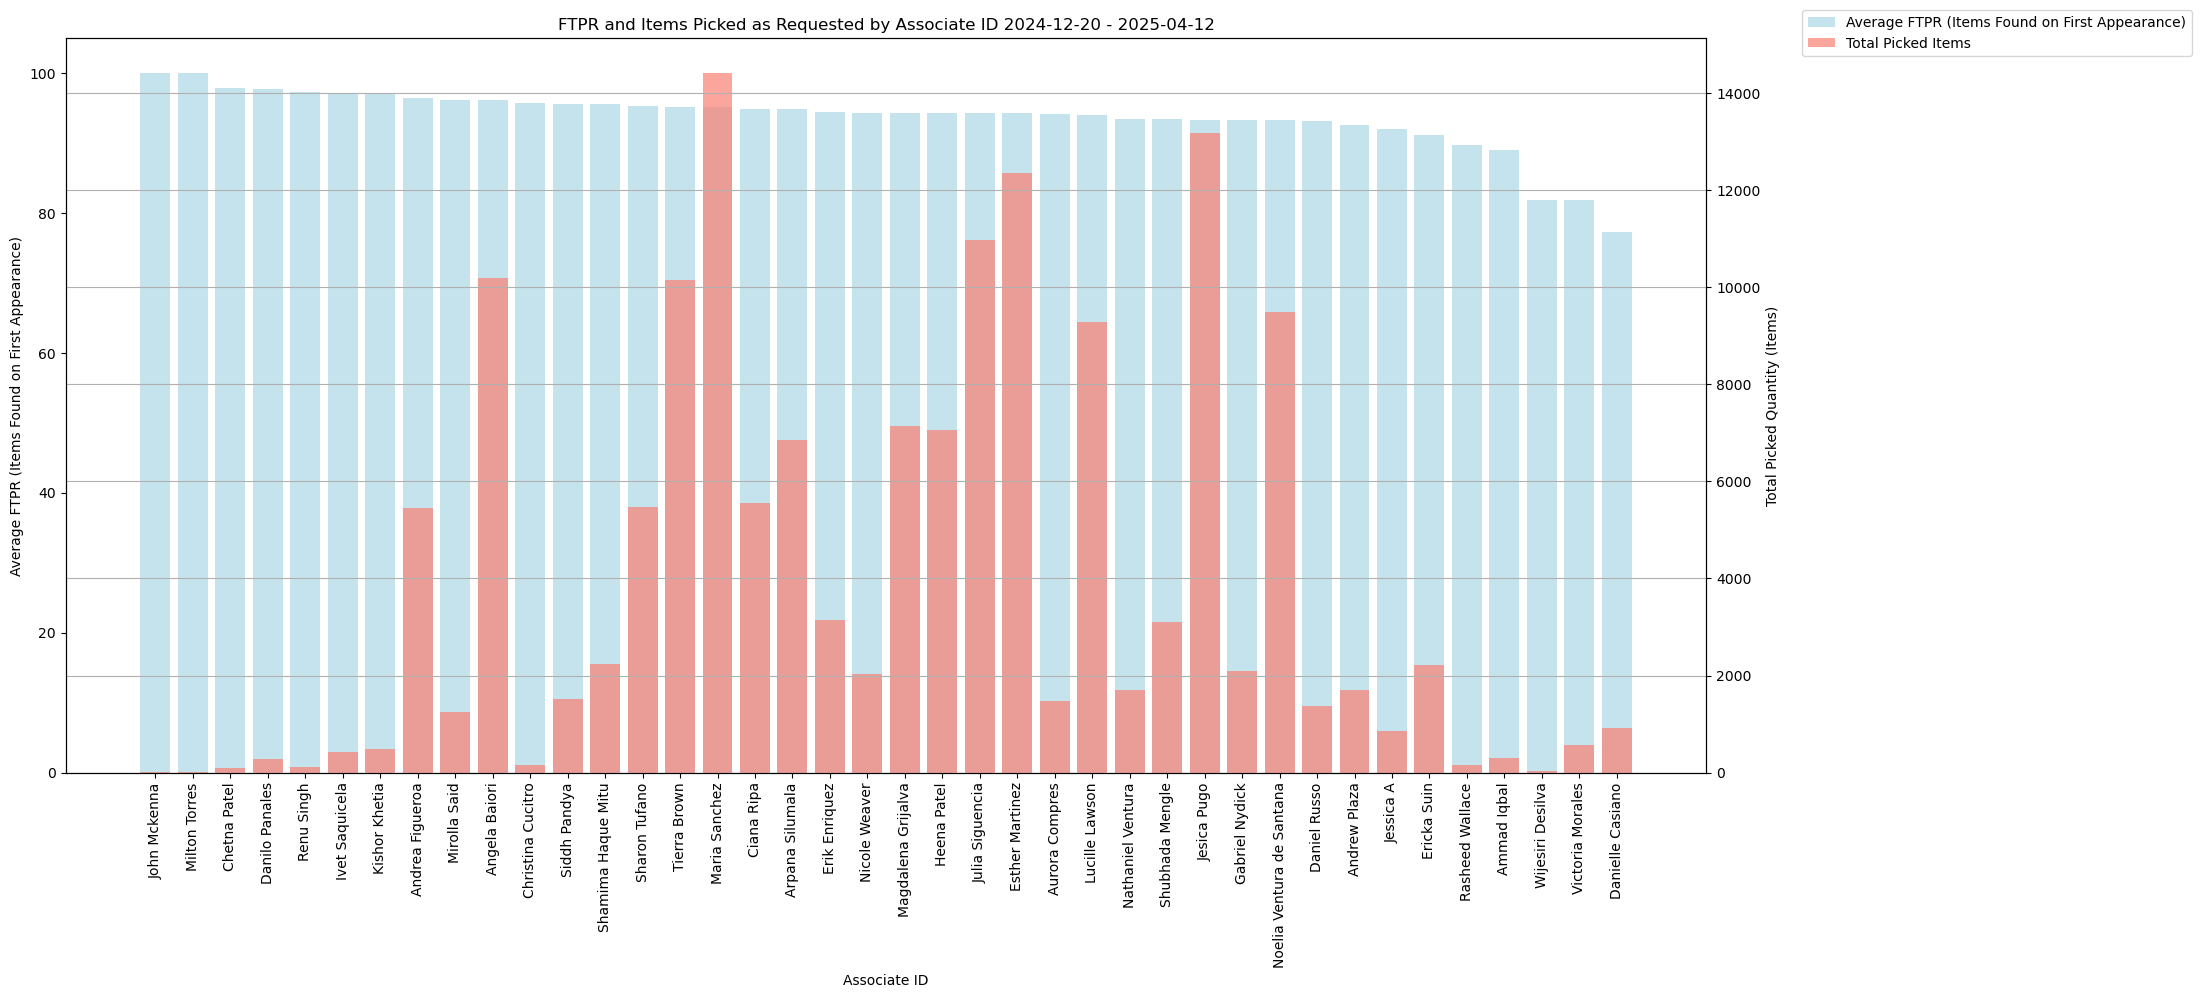

In [36]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['FTPR'] = pd.to_numeric(df['FTPR'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df.dropna(subset=['Picked As Req Qty', 'FTPR'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_ftpr = df_clean.groupby('Associate Name')['FTPR'].mean().astype(float).sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate Name')['Picked As Req Qty'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_ftpr.index, avg_ftpr, color='lightblue', alpha=0.7, label='Average FTPR (Items Found on First Appearance)')
ax1.set_xlabel('Associate ID')
ax1.set_ylabel('Average FTPR (Items Found on First Appearance)')
ax1.set_title(f'FTPR and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()

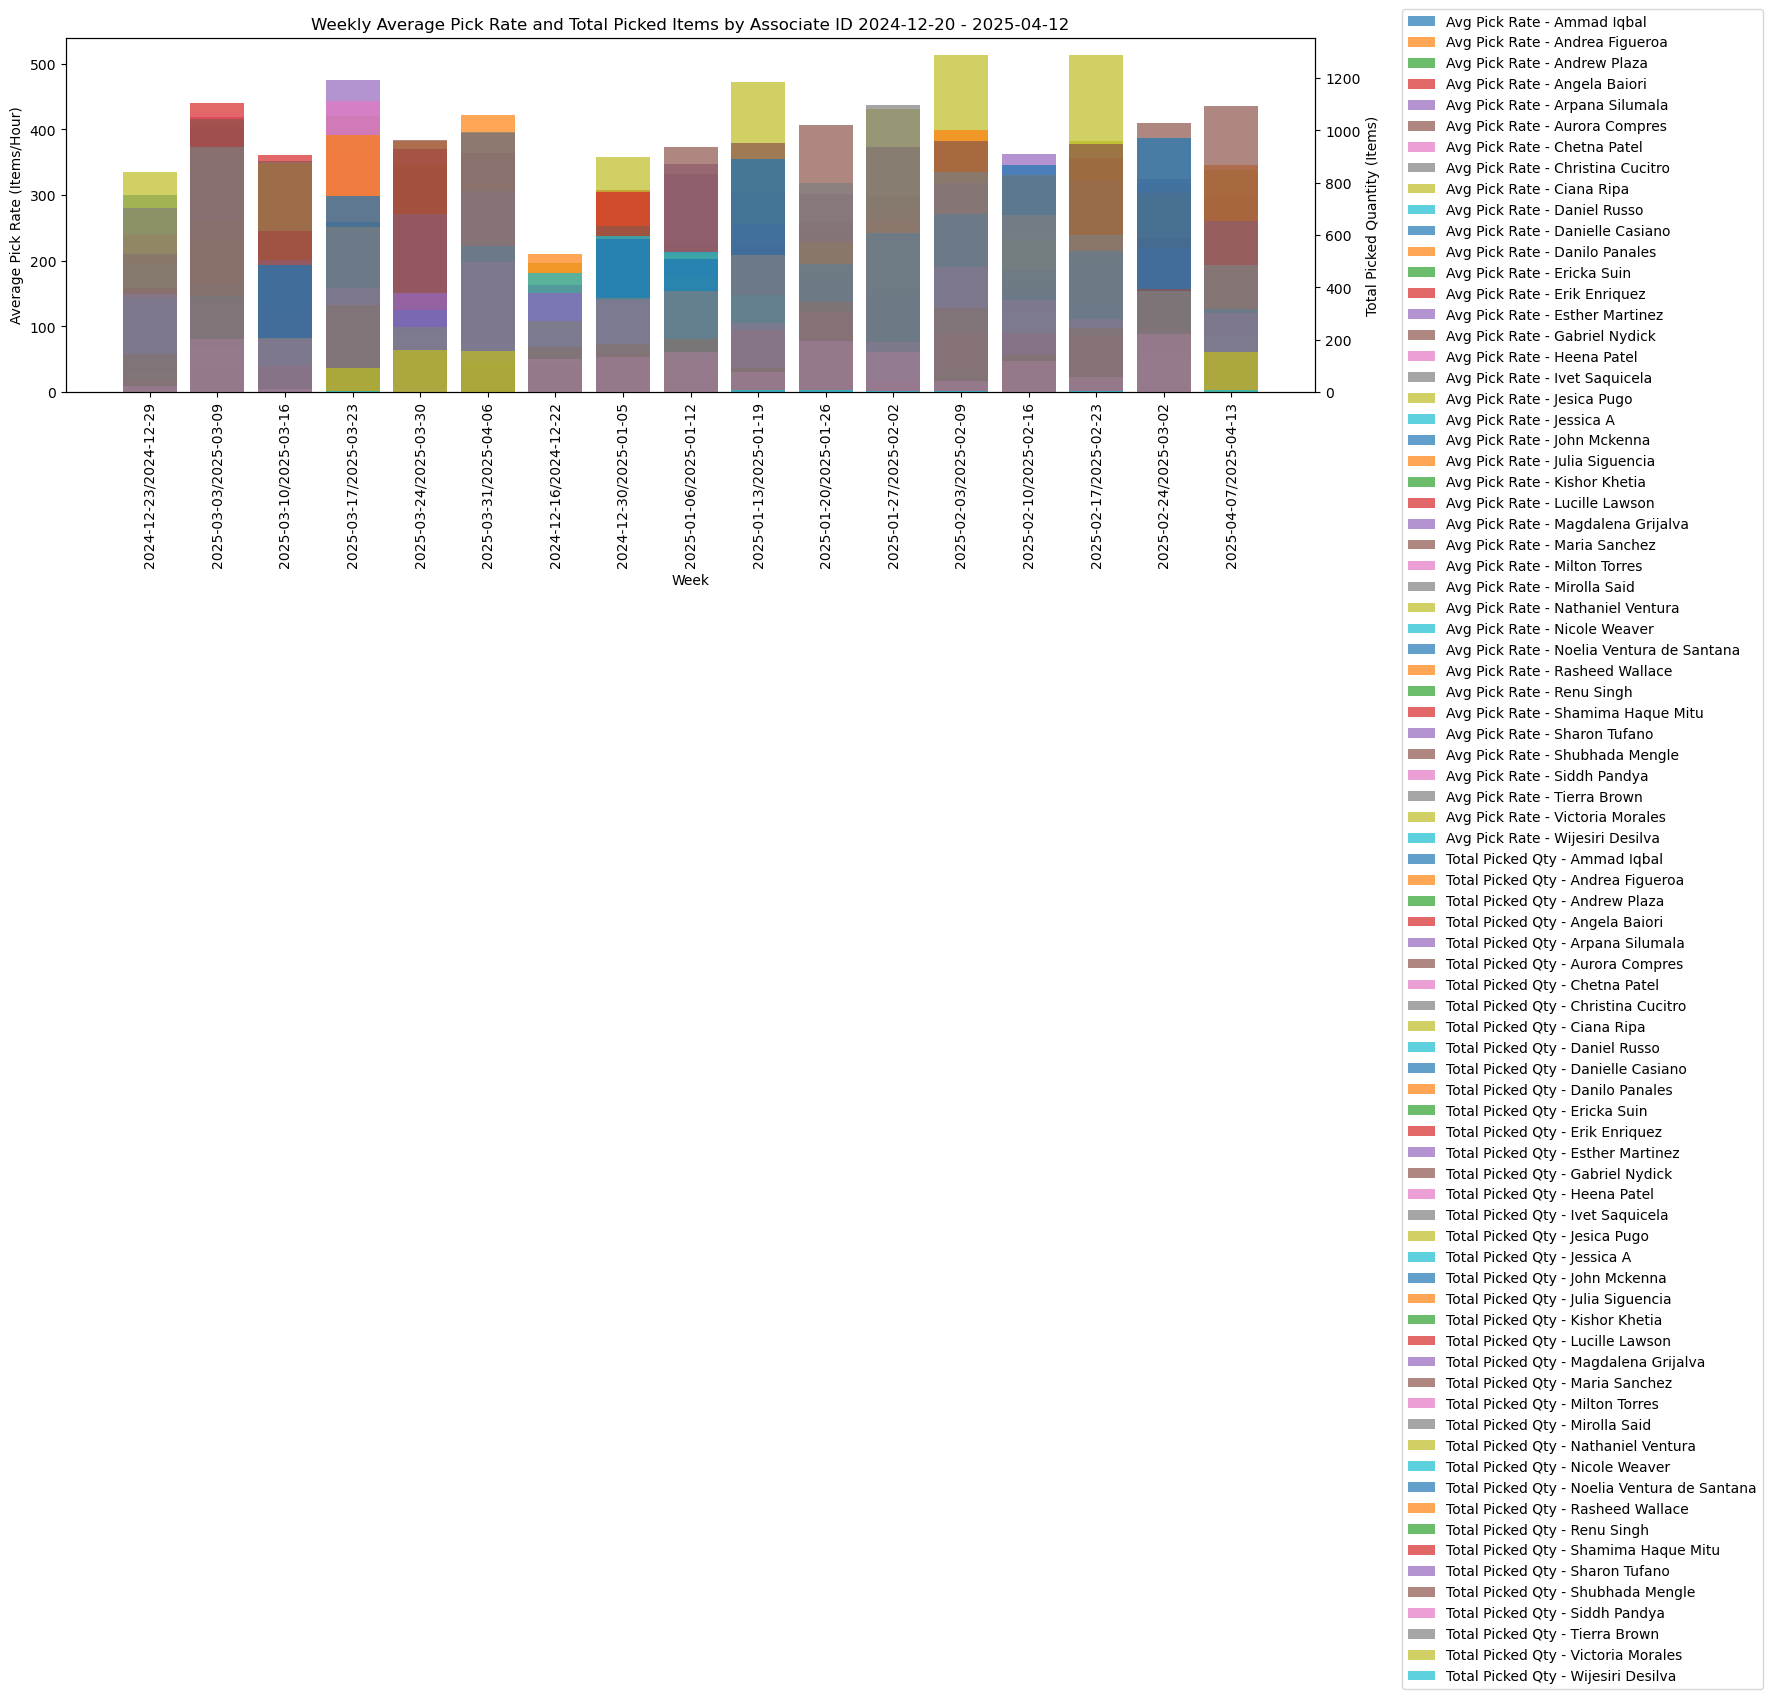

In [37]:
# Ensure columns like 'Picked As Req Qty' and 'Pick Rate' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and week (using 'Day of Pick Date' for weekly grouping)
# We're using pd.Grouper to group by week and Associate ID
df_clean['Week'] = df_clean['Day of Pick Date'].dt.to_period('W')

# Group by Week and Associate ID to calculate the sum of 'Picked As Req Qty' and average 'Pick Rate'
weekly_data = df_clean.groupby(['Week', 'Associate Name']).agg(
    avg_pick_rate=('Pick Rate', 'mean'),
    total_picked_qty=('Picked As Req Qty', 'sum')
).reset_index()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty by Week
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for average Pick Rate (items per hour) by Week
for label, data in weekly_data.groupby('Associate Name'):
    ax1.bar(data['Week'].astype(str), data['avg_pick_rate'], label=f'Avg Pick Rate - {label}', alpha=0.7)

ax1.set_xlabel('Week')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Weekly Average Pick Rate and Total Picked Items by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()

# Bar plot for total Picked As Req Qty by Week
for label, data in weekly_data.groupby('Associate Name'):
    ax2.bar(data['Week'].astype(str), data['total_picked_qty'], label=f'Total Picked Qty - {label}', alpha=0.7)

ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Week
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


In [38]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

'''# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution in y_train
print("Class distribution in y_train:")
print(Counter(y_train))

# Check class distribution in y_test
print("\nClass distribution in y_test:")
print(Counter(y_test))

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Get probabilistic predictions (probabilities of the positive class)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score
threshold = 0.5  # You can adjust this threshold as needed
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilistic predictions here

print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")'''

'# Assuming X and y are your features and target variable\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Check class distribution in y_train\nprint("Class distribution in y_train:")\nprint(Counter(y_train))\n\n# Check class distribution in y_test\nprint("\nClass distribution in y_test:")\nprint(Counter(y_test))\n\n# Oversample the minority class\nros = RandomOverSampler(random_state=42)\nX_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)\n\n# Initialize and train the model\nmodel = RandomForestClassifier(random_state=42)\nmodel.fit(X_train_resampled, y_train_resampled)\n\n# Get probabilistic predictions (probabilities of the positive class)\ny_pred_proba = model.predict_proba(X_test)[:, 1]\n\n# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score\nthreshold = 0.5  # You can adjust this threshold as needed\ny_pred = (y_pred_proba >= threshold).astype(int)\n\n# Calculate metrics\n

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Assuming df is the DataFrame containing your data
threshold_pick_rate = 50
threshold_ftpr = 97.5
'''df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) | 
                            (df['FTPR'] > threshold_ftpr)).astype(int)'''
df['Handled_Exceptions'] = (
    (df['Pick Rate'] < threshold_pick_rate) | 
    (df['FTPR'] > threshold_ftpr) | 
    (df['Exception Qty Req to Pick'] > 0) | 
    (df['Exception Nil Pick Qty'] > 0)
).astype(int)

print(df['Handled_Exceptions'].value_counts())

features = ['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']
target = 'Handled_Exceptions'
X = df[features]
y = df[target]

# Check if there are at least two classes in y
if len(np.unique(y)) < 2:
    print("Only one class present in the target variable. Cannot calculate ROC AUC score.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check if there are at least two classes in both y_train and y_test
    if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
        print("Only one class present in either the training or test set. Cannot calculate ROC AUC score.")
    else:
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Calculate ROC AUC score only if there are at least two classes in y_test
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"ROC AUC: {roc_auc}")

# Perform grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Calculate cross-validation score
cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)
print(f"Cross-Validation Scores: {cross_val_scores}")

Handled_Exceptions
1    1018
0     361
Name: count, dtype: int64
Accuracy: 0.8623188405797102
Precision: 0.9621621621621622
Recall: 0.8516746411483254
F1 Score: 0.9035532994923858
ROC AUC: 0.9184817539098764
Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Best Score: 0.8848457424928012
Cross-Validation Scores: [0.88235294 0.90497738 0.88235294 0.87272727 0.88181818]


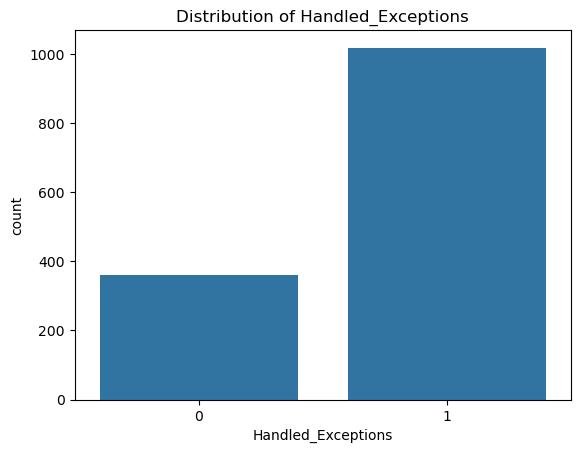

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Handled_Exceptions', data=df)
plt.title('Distribution of Handled_Exceptions')
plt.show()


In [41]:
start_time = time.time()
# Threshold ranges to test
threshold_pick_rate_values = np.linspace(5, 500, 8)  # Adjusted range, 100 
#print(threshold_pick_rate_values)
threshold_ftpr_values = np.linspace(70, 105, 12)       # Adjusted range, 300

# Variables to store the best thresholds and corresponding F1 score
best_thresholds = None
best_f1_score = -np.inf  # Initialize to a very low value
results = []  # Store results for each threshold combination

# Debugging: Check initial conditions
#print("Initial Threshold Values:")
#print(f"Pick Rate Thresholds: {threshold_pick_rate_values}")
#print(f"FTPR Thresholds: {threshold_ftpr_values}")

# Iterate through threshold combinations
for threshold_pick_rate in threshold_pick_rate_values:
    for threshold_ftpr in threshold_ftpr_values:
        # Create target variable based on thresholds
        df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) |
                                    (df['FTPR'] > threshold_ftpr)).astype(int)
        y = df['Handled_Exceptions']
        X = df[['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']]

        # Debugging: Check class distribution
        #print(f"Testing thresholds: Pick Rate={threshold_pick_rate}, FTPR={threshold_ftpr}")
        #print(f"Class distribution in 'y': {np.unique(y, return_counts=True)}")
        
        # Skip if there is only one class in the target variable
        if len(np.unique(y)) < 2:
            #print("Skipping: Only one class present in target variable")
            continue

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Skip if train/test split results in a single class
        if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
            #print("Skipping: Only one class present in train/test sets")
            continue

        # Train a Random Forest model
        model = RandomForestClassifier(random_state=42) ############### n_jobs
        model.fit(X_train, y_train)

        # Make predictions and calculate F1 score
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)

        # Debugging: Print F1 score for the current thresholds
        #print(f"F1 Score for thresholds {threshold_pick_rate}, {threshold_ftpr}: {f1}")

        # Update the best thresholds if current F1 is higher
        if f1 > best_f1_score:
            best_f1_score = f1
            best_thresholds = (threshold_pick_rate, threshold_ftpr)
            #print(f"Updated Best Thresholds: {best_thresholds} with F1={best_f1_score}")

        # Store the results for analysis
        results.append({
            'Pick Rate Threshold': threshold_pick_rate,
            'FTPR Threshold': threshold_ftpr,
            'F1 Score': f1
        })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Display the best thresholds and their corresponding F1 score
if best_thresholds is None:
    print("No valid threshold combination was found. Adjust thresholds or data distribution.")
else:
    print(f"Best Thresholds: Pick Rate={best_thresholds[0]}, FTPR={best_thresholds[1]}")
    print(f"Best F1 Score: {best_f1_score}")

# Optional: Summarize all tested threshold combinations
if not results_df.empty:
    print("Summary of Top Threshold Combinations:")
    print(results_df.sort_values(by='F1 Score', ascending=False).head())
else:
    print("No valid results were generated.")
end_time = time.time()
print(f'time to run model for {threshold_pick_rate_values.size * threshold_ftpr_values.size} combinations: {end_time - start_time}')

Best Thresholds: Pick Rate=5.0, FTPR=70.0
Best F1 Score: 1.0
Summary of Top Threshold Combinations:
    Pick Rate Threshold  FTPR Threshold  F1 Score
0              5.000000       70.000000       1.0
25           217.142857      105.000000       1.0
18            75.714286      105.000000       1.0
17            75.714286      101.818182       1.0
24           217.142857      101.818182       1.0
time to run model for 96 combinations: 1.4165928363800049


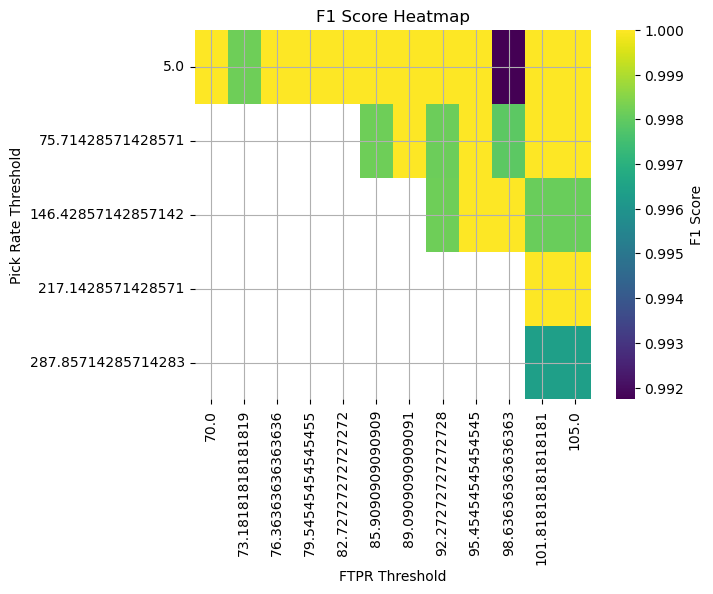

In [42]:
# Ensure results_df is not empty
if not results_df.empty:
    # Rename columns for compatibility with pivot (optional, just for consistency)
    results_df.rename(columns={
        'Pick Rate Threshold': 'pick_rate',
        'FTPR Threshold': 'ftpr',
        'F1 Score': 'f1'
    }, inplace=True)

    # Create pivot table
    pivot_table = results_df.pivot(index='pick_rate', columns='ftpr', values='f1')

    # Generate heatmap
    sns.heatmap(pivot_table, annot=False, fmt=".3f", cmap="viridis", cbar_kws={'label': 'F1 Score'})
    plt.title("F1 Score Heatmap")
    plt.xlabel("FTPR Threshold")
    plt.ylabel("Pick Rate Threshold")
    plt.grid()
    plt.show()
else:
    print("No data to plot. Ensure valid results are generated before creating a heatmap.")

In [43]:
print(df['Pick Rate'].describe())
print(df['FTPR'].describe())
print(df['Handled_Exceptions'].value_counts())
feature_importances = model.feature_importances_
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")


count    1379.000000
mean       63.913633
std        43.969200
min         0.000000
25%        43.000000
50%        55.000000
75%        72.000000
max       720.000000
Name: Pick Rate, dtype: float64
count    1379.000000
mean       94.011494
std         9.196740
min         0.000000
25%        92.590000
50%        95.770000
75%        98.530000
max       115.630000
Name: FTPR, dtype: float64
Handled_Exceptions
1    1377
0       2
Name: count, dtype: int64
FTPR: 0.005642994873088356
Pick Rate: 0.7339023134967775
Pick Hours: 0.1871553547230072
Qty Req to Pick: 0.023986218974369717
Picked As Req Qty: 0.04931311793275731


<h2>Composite Scoring Starts Here</h2>
<h4>Composite Scoring Modifiers for standardized evaluation throughtout notebook</h4>
<ul>pickrate_modifier</ul>
<ul>ftpr_modifier</ul>
<ul>picked_as_req_modifier</ul>

<h1>Composite Score Modifiers</h1>

In [44]:
pickrate_modifier = 0.6
ftpr_modifier = 0.2
picked_as_req_modifier = 0.2
picked_as_req_composite_threshold = 50

In [45]:
# Define a composite score for each row (or use one metric like 'Pick Rate' directly)
df['Composite_Score'] = (
    picked_as_req_modifier * df['Picked As Req Qty'] +  # Weight for Items Picked
    pickrate_modifier * df['Pick Rate'] +       # Weight for Pick Rate
    ftpr_modifier * df['FTPR']              # Weight for FTPR
)

# Find the best day for each associate
best_days = df.loc[df.groupby('Associate Name')['Composite_Score'].idxmax()]

# Sort associates by their best day's composite score unfiltered
top_associates = best_days.sort_values(by=['Composite_Score', 'Day of Pick Date'], ascending=[False, False])

# Display the top associates and their best day
print(top_associates[['Associate Name', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite_Score']].head(10))

# Filter out associates with fewer than a certain number of items picked
best_days_filtered = best_days[best_days['Picked As Req Qty'] > picked_as_req_composite_threshold]

# Sort associates by their best day's composite score filtered
top_associates_filtered = best_days_filtered.sort_values(by=['Composite_Score', 'Day of Pick Date'], ascending=[False, False])

# Display the top associates and their best day after pick qty filtered
print(f'\nAfter filtering out Associates with < 50 Picked As Req Qty')
print(top_associates_filtered[['Associate Name', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite_Score']].head(10))

         Associate Name Day of Pick Date  Picked As Req Qty  Pick Rate    FTPR  Composite_Score
2180     Gabriel Nydick       2025-01-30                  2      720.0  100.00          452.400
3003  Nathaniel Ventura       2025-02-21                  1      514.0  100.00          328.600
360      Danilo Panales       2025-01-28                  4      379.0  100.00          248.200
2473         Ciana Ripa       2025-01-13                192      300.0   83.12          235.024
2649       John Mckenna       2024-12-24                  6      300.0  100.00          201.200
923     Rasheed Wallace       2025-03-20                  2      300.0  100.00          200.400
1165        Heena Patel       2025-03-15                522      102.3   97.56          185.292
3090       Tierra Brown       2025-02-02                469      105.0   99.79          176.758
2462  Christina Cucitro       2024-12-31                  4      253.0  100.00          172.600
2178    Esther Martinez       2025-01-30

In [46]:
#df.loc[df["Associate ID"] == 'n0v0359']

<h2>Top Composite Score of the Week</h2>

In [47]:
#Top Associate Per Week
# Aggregate metrics for each associate per week
weekly_performance = df.groupby(['Custom Week Start', 'Associate Name'], as_index=False).agg({
    'Picked As Req Qty': 'sum',  # Total items picked in the week
    'Pick Rate': 'mean',       # Average pick rate for the week
    'FTPR': 'mean',            # Average FTPR for the week
    'Pick Hours': 'sum'        # Total hours worked in the week (optional)
})

# Add a composite score to rank performance in each week
weekly_performance['Composite_Score'] = (
    picked_as_req_modifier * weekly_performance['Picked As Req Qty'] +
    pickrate_modifier * weekly_performance['Pick Rate'] +
    ftpr_modifier * weekly_performance['FTPR']
)

# Sort associates within each week by Composite Score
weekly_performance = weekly_performance.sort_values(by=['Custom Week Start', 'Composite_Score'], ascending=[True, False])

# Add a rank column within each week
weekly_performance['Rank'] = weekly_performance.groupby('Custom Week Start')['Composite_Score'].rank(method='dense', ascending=False)

# Get the top associate for each week
top_associates_per_week = weekly_performance[weekly_performance['Rank'] == 1]

# Display the results
#print(top_associates_per_week[['Custom Week Start', 'Associate Name', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite_Score']])
top_associates_per_week[['Custom Week Start', 'Associate Name', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite_Score']]


,Custom Week Start,Associate Name,Picked As Req Qty,Pick Rate,FTPR,Composite_Score
7,2024-12-14,Julia Siguencia,336,68.000000,92.020000,126.404000
27,2024-12-21,Jesica Pugo,771,62.200000,92.556000,210.031200
58,2024-12-28,Jesica Pugo,921,85.000000,93.254000,253.850800
91,2025-01-04,Maria Sanchez,929,66.600000,95.660000,244.892000
118,2025-01-11,Maria Sanchez,883,50.400000,93.936000,225.627200
145,2025-01-18,Maria Sanchez,1048,72.000000,96.088000,272.017600
172,2025-01-25,Maria Sanchez,962,66.400000,97.222000,251.684400
193,2025-02-01,Jesica Pugo,1257,92.400000,93.932000,325.626400
221,2025-02-08,Jesica Pugo,936,79.000000,93.292500,253.258500
256,2025-02-15,Nathaniel Ventura,1,514.000000,100.000000,328.600000


<h2>WTD Composite Score Rankings</h2>

In [48]:
# Calculate Composite Score (can modify the weights here as needed)
df['Composite_Score'] = (df['Pick Rate'] * pickrate_modifier) + (df['FTPR'] * ftpr_modifier) + (df['Picked As Req Qty'] * picked_as_req_modifier)

# Filter rows where Picked As Req Qty is less than num
num = 1
df_filtered = df[df['Picked As Req Qty'] >= num]

# Specify the week for analysis
week_of_interest = '2025-01-18 to 2025-01-24' #manual range
week_of_interest = df["Week"].max() #defaults to most recent week

# Filter the data for the specified week
df_week = df_filtered[df_filtered['Week'] == week_of_interest]

# Get the best day per associate within the week based on Composite_Score
best_day_of_week = df_week.loc[df_week.groupby('Associate Name')['Composite_Score'].idxmax()]
best_day_of_week = best_day_of_week.loc[best_day_of_week['Picked As Req Qty'] >= picked_as_req_composite_threshold]

# Rank the associates based on Composite_Score within the week
best_day_of_week['Rank'] = best_day_of_week['Composite_Score'].rank(ascending=False, method='min')

# Sort by rank (ascending gives top performer first)
best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

# Display the results
print('WTD Composite Scores')
print(f'Week: {week_of_interest}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']])
best_day_of_week_printdf = best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']]
best_day_of_week_printdf.head(30)

WTD Composite Scores
Week: 2025-04-12 to 2025-04-18


,Associate Name,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Composite_Score,Rank
2298,Jesica Pugo,2025-04-12,78.5,91.51,306,126.602,1.0
2292,Esther Martinez,2025-04-12,78.7,97.40,188,104.300,2.0
2302,Maria Sanchez,2025-04-12,51.6,96.06,245,99.172,3.0
2280,Ciana Ripa,2025-04-12,84.6,96.49,110,92.058,4.0
2296,Heena Patel,2025-04-12,71.4,97.22,141,90.484,5.0
2300,Julia Siguencia,2025-04-12,65.0,93.57,135,84.714,6.0
2278,Andrew Plaza,2025-04-12,65.2,97.73,87,76.066,7.0
2290,Ericka Suin,2025-04-12,50.4,85.54,142,75.748,8.0
2304,Nathaniel Ventura,2025-04-12,65.0,81.82,77,70.764,9.0
2308,Shamima Haque Mitu,2025-04-12,55.1,87.72,50,60.604,10.0


<h2>Composite Score Rankings LW</h2>

In [49]:
# Calculate Composite Score
df['Composite_Score'] = (
    (df['Pick Rate'] * pickrate_modifier) + 
    (df['FTPR'] * ftpr_modifier) + 
    (df['Picked As Req Qty'] * picked_as_req_modifier)
)

# Set today’s date
today = datetime.now()

# Find the last full week's end date (before today)
last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()

# Get the corresponding start date for that week
last_full_week_start = df['Custom Week Start'][df['Custom Week End'] == last_full_week_end].max()

# Filter data for the last full week
df_week = df[(df['Custom Week Start'] == last_full_week_start) & (df['Custom Week End'] == last_full_week_end)]

# Get the best day per associate within the last full week based on Composite_Score
best_day_of_week = df_week.loc[df_week.groupby('Associate Name')['Composite_Score'].idxmax()].copy()

# Filter out associates with fewer than the composite threshold
best_day_of_week = best_day_of_week.loc[best_day_of_week['Picked As Req Qty'] >= picked_as_req_composite_threshold]
# Rank associates by Composite_Score (descending order)
best_day_of_week['Rank'] = best_day_of_week['Composite_Score'].rank(ascending=False, method='min')

# Sort by rank
best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

# Display results
print('LW Composite Scores')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']].head(15))
best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']].head(30)

LW Composite Scores
Week: 2025-04-05 - 2025-04-11


,Associate Name,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Composite_Score,Rank
2003,Jesica Pugo,2025-04-06,135.7,94.72,312,162.764,1.0
1921,Ciana Ripa,2025-04-06,108.9,93.15,350,153.970,2.0
283,Julia Siguencia,2025-04-08,74.7,93.33,370,137.486,3.0
316,Tierra Brown,2025-04-10,68.0,95.03,325,124.806,4.0
237,Arpana Silumala,2025-04-11,58.6,96.30,338,122.020,5.0
292,Maria Sanchez,2025-04-07,59.2,92.42,329,119.804,6.0
1995,Heena Patel,2025-04-05,66.5,92.57,257,109.814,7.0
2020,Lucille Lawson,2025-04-05,56.8,94.86,278,108.652,8.0
298,Nathaniel Ventura,2025-04-08,103.3,95.87,116,104.354,9.0
233,Angela Baiori,2025-04-10,50.3,95.31,266,102.442,10.0


<h2>Lowest Performing Associates by Day LW (Composite Score)</h2>

In [50]:
# Get the best day per associate within the last full week based on Composite_Score
worst_day_of_week = df_week.loc[df_week.groupby('Associate Name')['Composite_Score'].idxmin()].copy()

# Rank associates by Composite_Score (descending order)
worst_day_of_week['Rank'] = worst_day_of_week['Composite_Score'].rank(ascending=False, method='min')

# Sort by rank
worst_day_of_week_sorted = worst_day_of_week.sort_values(by='Rank', ascending=False)

# Display results
print('Lowest Performing Associates by Day LW (Composite Score)')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']].head(15))
worst_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']].head(15)

Lowest Performing Associates by Day LW (Composite Score)
Week: 2025-04-05 - 2025-04-11


,Associate Name,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Composite_Score,Rank
1966,Ericka Suin,2025-04-06,9.1,46.15,6,15.890,29.0
250,Danielle Casiano,2025-04-11,13.5,40.00,16,19.300,28.0
319,Victoria Morales,2025-04-11,6.2,72.09,31,24.338,27.0
257,Danilo Panales,2025-04-09,30.3,100.00,6,39.380,26.0
242,Ciana Ripa,2025-04-11,34.4,85.71,13,40.382,25.0
1882,Andrea Figueroa,2025-04-05,34.4,100.00,2,41.040,24.0
1914,Christina Cucitro,2025-04-06,55.4,66.67,4,47.374,23.0
2071,Noelia Ventura de Santana,2025-04-05,41.0,80.77,47,50.154,22.0
314,Sharon Tufano,2025-04-07,24.3,94.44,85,50.468,21.0
247,Daniel Russo,2025-04-08,46.9,96.15,25,52.370,20.0


<h2>Lowest FTPR Associates for LW</h2>

In [51]:
lowest_ftpr = df_week.loc[df_week.groupby('Associate Name')['FTPR'].idxmin()].copy()
#lowest_ftpr = df_week.loc[df_week.groupby('Associate Name')['FTPR'] <= 90.0].copy()

lowest_ftpr = lowest_ftpr.loc[lowest_ftpr['FTPR'] <= 90.0]
# Rank associates by Composite_Score (descending order)
lowest_ftpr['Rank'] = lowest_ftpr['Composite_Score'].rank(ascending=True, method='min')
lowest_ftpr = lowest_ftpr.sort_values(by='FTPR', ascending=True)
# Display results
print('Lowest FTPR WTD <= 90.0 %')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']].head(15))
lowest_ftpr[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite_Score', 'Rank']]


Lowest FTPR WTD <= 90.0 %
Week: 2025-04-05 - 2025-04-11


,Associate Name,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Composite_Score,Rank
250,Danielle Casiano,2025-04-11,13.5,40.00,16,19.300,2.0
1966,Ericka Suin,2025-04-06,9.1,46.15,6,15.890,1.0
1914,Christina Cucitro,2025-04-06,55.4,66.67,4,47.374,5.0
319,Victoria Morales,2025-04-11,6.2,72.09,31,24.338,3.0
2071,Noelia Ventura de Santana,2025-04-05,41.0,80.77,47,50.154,6.0
1887,Andrew Plaza,2025-04-06,40.4,83.33,93,59.506,10.0
2111,Shubhada Mengle,2025-04-06,24.1,83.94,117,54.648,8.0
262,Erik Enriquez,2025-04-10,66.6,85.11,90,74.982,11.0
242,Ciana Ripa,2025-04-11,34.4,85.71,13,40.382,4.0
248,Daniel Russo,2025-04-07,46.8,86.21,50,55.322,9.0


<h2>Model to Predict FTPR and Pick Rate</h2>

In [52]:
'''
WORKS, BUT DOES NOT HAVE ALL 3 METRICS. USE FURTHER CELL FOR MODELS
'''

'''
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

start_time = time.time()
# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV for FTPR prediction
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

# Print best parameters and corresponding score for FTPR prediction
print("Best Parameters for FTPR:", grid_search_ftpr.best_params_)
print("Best Score for FTPR:", -grid_search_ftpr.best_score_)

# Train a model with the best parameters and evaluate on test data for FTPR prediction
best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

# Print evaluation metrics for FTPR prediction
print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Pick Rate prediction
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

# Print best parameters and corresponding score for Pick Rate prediction
print("Best Parameters for Pick Rate:", grid_search_pick_rate.best_params_)
print("Best Score for Pick Rate:", -grid_search_pick_rate.best_score_)

# Train a model with the best parameters and evaluate on test data for Pick Rate prediction
best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

# Print evaluation metrics for Pick Rate prediction
print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Use the trained models to predict performance for each associate in df
df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))

end_time = time.time()
print(f'Total time: {end_time - start_time}')
# Print predicted metrics for each associate
for associate_id in df['Associate ID'].unique():
    associate_df = df[df['Associate ID'] == associate_id]
    print(f"Associate ID: {associate_id}")
    print("Predicted Metrics:")
    print(associate_df[['FTPR', 'Pick Rate', 'Predicted FTPR', 'Predicted Pick Rate']])
    print()
df.head(10)
'''

'\n# Import necessary libraries\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.model_selection import GridSearchCV\n\nstart_time = time.time()\n# Define features (X) and target variables (y)\nX = df[[\'Pick Hours\', \'Qty Req to Pick\', \'Picked As Req Qty\', \n        \'Substitution Qty\', \'Nil Pick Qty\', \'Exception Qty Req to Pick\', \n        \'Exception Picked As Req Qty\', \'Exception Substitution Qty\', \'Exception Nil Pick Qty\']]\ny_ftpr = df[\'FTPR\']\ny_pick_rate = df[\'Pick Rate\']\n\n# Split data into training and testing sets\nX_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)\n_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)\n\n# Scale features using StandardScaler\nscaler = Stan

<h2>Predicts Team Average values based on all Historical Data</h2>

In [53]:
'''
WORKS, BUT DOES NOT HAVE ALL 3 METRICS. USE FURTHER CELL FOR MODELS
'''

'''

# Adds Picked as Req Qty to predictions

start_time = time.time()
# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 'Substitution Qty', 
        'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV for FTPR prediction
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

# Print best parameters and corresponding score for FTPR prediction
print("Best Parameters for FTPR:", grid_search_ftpr.best_params_)
print("Best Score for FTPR:", -grid_search_ftpr.best_score_)

# Train a model with the best parameters and evaluate on test data for FTPR prediction
best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

# Print evaluation metrics for FTPR prediction
print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Pick Rate prediction
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

# Print best parameters and corresponding score for Pick Rate prediction
print("Best Parameters for Pick Rate:", grid_search_pick_rate.best_params_)
print("Best Score for Pick Rate:", -grid_search_pick_rate.best_score_)

# Train a model with the best parameters and evaluate on test data for Pick Rate prediction
best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

# Print evaluation metrics for Pick Rate prediction
print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Train a Random Forest Regressor model for Picked As Req Qty prediction
model_picked_as_req_qty = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Picked As Req Qty prediction
grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

# Print best parameters and corresponding score for Picked As Req Qty prediction
print("Best Parameters for Picked As Req Qty:", grid_search_picked_as_req_qty.best_params_)
print("Best Score for Picked As Req Qty:", -grid_search_picked_as_req_qty.best_score_)

# Train a model with the best parameters and evaluate on test data for Picked As Req Qty prediction
best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

# Print evaluation metrics for Picked As Req Qty prediction
print("Picked As Req Qty Prediction Metrics:")
print(f"MSE: {picked_as_req_qty_mse}")
print(f"R2 Score: {picked_as_req_qty_r2}")

# Use the trained models to predict performance for each associate
predicted_df = pd.DataFrame({
    'FTPR': y_pred_ftpr,
    'Pick Rate': y_pred_pick_rate,
    'Picked As Req Qty': y_pred_picked_as_req_qty
})

print(predicted_df.head())

# Calculate overall metrics
overall_mse = (ftpr_mse + pick_rate_mse + picked_as_req_qty_mse) / 3
overall_r2 = (ftpr_r2 + pick_rate_r2 + picked_as_req_qty_r2) / 3

end_time = time.time()
print(f"Overall MSE: {overall_mse}")
print(f"Overall R2 Score: {overall_r2}")
print(f'Total time: {end_time - start_time}')
######before n_jobs=-1, total time = 85.37645697593689 M4 Max

'''

'\n\n# Adds Picked as Req Qty to predictions\n\nstart_time = time.time()\n# Define features (X) and target variables (y)\nX = df[[\'Pick Hours\', \'Qty Req to Pick\', \'Substitution Qty\', \n        \'Nil Pick Qty\', \'Exception Qty Req to Pick\', \n        \'Exception Picked As Req Qty\', \'Exception Substitution Qty\', \'Exception Nil Pick Qty\']]\ny_ftpr = df[\'FTPR\']\ny_pick_rate = df[\'Pick Rate\']\ny_picked_as_req_qty = df[\'Picked As Req Qty\']\n\n# Split data into training and testing sets\nX_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)\n_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)\n_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)\n\n# Scale features using StandardScaler\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transf

In [54]:
df.head()

,Associate ID,Associate Name,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,...,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Custom Week Start,Custom Week End,Week,Handled_Exceptions,Composite_Score
431,a0b0ad9,Angela Baiori,2025-02-05,97.01,233,0,60.0,3.86,227,4.0,...,0.0,0.0,0,0,233,2025-02-01,2025-02-07,2025-02-01 to 2025-02-07,1,100.802
3066,a0b0ad9,Angela Baiori,2025-02-02,97.03,268,0,59.0,4.36,254,2.0,...,0.0,0.0,0,0,268,2025-02-01,2025-02-07,2025-02-01 to 2025-02-07,1,105.606
2401,a0b0ad9,Angela Baiori,2024-12-29,92.92,214,0,42.0,4.88,199,6.0,...,0.0,0.0,0,0,214,2024-12-28,2025-01-03,2024-12-28 to 2025-01-03,1,83.584
2402,a0b0ad9,Angela Baiori,2024-12-27,100.00,47,0,79.0,0.60,47,0.0,...,0.0,0.0,0,0,47,2024-12-21,2024-12-27,2024-12-21 to 2024-12-27,1,76.800
2403,a0b0ad9,Angela Baiori,2024-12-26,92.66,223,0,51.0,4.18,212,3.0,...,0.0,2.0,0,0,223,2024-12-21,2024-12-27,2024-12-21 to 2024-12-27,1,91.532


In [55]:
'''



was commented out section
'''
'''
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()

# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick',
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning using GridSearchCV for FTPR prediction
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

# Print best parameters and corresponding score for FTPR prediction
print("Best Parameters for FTPR:", grid_search_ftpr.best_params_)
print("Best Score for FTPR:", -grid_search_ftpr.best_score_)

# Train a model with the best parameters and evaluate on test data for FTPR prediction
best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

# Print evaluation metrics for FTPR prediction
print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Pick Rate prediction
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

# Print best parameters and corresponding score for Pick Rate prediction
print("Best Parameters for Pick Rate:", grid_search_pick_rate.best_params_)
print("Best Score for Pick Rate:", -grid_search_pick_rate.best_score_)

# Train a model with the best parameters and evaluate on test data for Pick Rate prediction
best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

# Print evaluation metrics for Pick Rate prediction
print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Train a Random Forest Regressor model for Picked As Req Qty prediction
model_picked_as_req_qty = RandomForestRegressor(random_state=42)

# Perform hyperparameter tuning using GridSearchCV for Picked As Req Qty prediction
grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

# Print best parameters and corresponding score for Picked As Req Qty prediction
print("Best Parameters for Picked As Req Qty:", grid_search_picked_as_req_qty.best_params_)
print("Best Score for Picked As Req Qty:", -grid_search_picked_as_req_qty.best_score_)

# Train a model with the best parameters and evaluate on test data for Picked As Req Qty prediction
best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

# Print evaluation metrics for Picked As Req Qty prediction
print("Picked As Req Qty Prediction Metrics:")
print(f"MSE: {picked_as_req_qty_mse}")
print(f"R2 Score: {picked_as_req_qty_r2}")

# Use the trained models to make predictions on the original data
df_predictions = df.copy()
df_predictions['Predicted_FTPR'] = best_model_ftpr.predict(scaler.fit_transform(X))
df_predictions['Predicted_Pick_Rate'] = best_model_pick_rate.predict(scaler.fit_transform(X))
df_predictions['Predicted_Picked_As_Req_Qty'] = best_model_picked_as_req_qty.predict(scaler.fit_transform(X))

end_time = time.time()
print(f"Time taken to execute the script: {end_time - start_time} seconds")'''

'\n# Import necessary libraries\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.model_selection import GridSearchCV\nimport time\n\nstart_time = time.time()\n\n# Define features (X) and target variables (y)\nX = df[[\'Pick Hours\', \'Qty Req to Pick\', \n        \'Substitution Qty\', \'Nil Pick Qty\', \'Exception Qty Req to Pick\',\n        \'Exception Picked As Req Qty\', \'Exception Substitution Qty\', \'Exception Nil Pick Qty\']]\ny_ftpr = df[\'FTPR\']\ny_pick_rate = df[\'Pick Rate\']\ny_picked_as_req_qty = df[\'Picked As Req Qty\']\n\n# Split data into training and testing sets\nX_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)\n_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)\n_, _, y_train_

<h2>Use these models to predict Metrics</h2>

In [56]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import time

start_time = time.time()

# Define features (X) and target variables (y)
X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']  # New target variable

#use model from above instead of training
# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter tuning space for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 500], #The number of decision trees in the forest. More trees = potentially better accuracy, but slower training.
    'max_depth': [None, 5, 10, 15], #means trees grow until all leaves are pure or contain fewer than min_samples_split. Smaller values prevent overfitting.
    'min_samples_split': [2, 5, 10, 15], # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4, 20, 50] #Minimum number of samples required in a leaf node (i.e., final nodes). Larger values create smoother, more generalized models
}

# Train a Random Forest Regressor model for FTPR prediction
model_ftpr = RandomForestRegressor(random_state=42)
grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

best_model_ftpr = grid_search_ftpr.best_estimator_
y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

print("FTPR Prediction Metrics:")
print(f"MSE: {ftpr_mse}")
print(f"R2 Score: {ftpr_r2}")

# Train a Random Forest Regressor model for Pick Rate prediction
model_pick_rate = RandomForestRegressor(random_state=42)
grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

best_model_pick_rate = grid_search_pick_rate.best_estimator_
y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

print("Pick Rate Prediction Metrics:")
print(f"MSE: {pick_rate_mse}")
print(f"R2 Score: {pick_rate_r2}")

# Train a Random Forest Regressor model for Picked As Req Qty prediction
model_picked_as_req_qty = RandomForestRegressor(random_state=42)
grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

print("Picked As Req Qty Prediction Metrics:")
print(f"MSE: {picked_as_req_qty_mse}")
print(f"R2 Score: {picked_as_req_qty_r2}")

# Use the trained models to predict performance for each associate in df
df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))
df['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaler.transform(X))

end_time = time.time()
print(f'Total time: {end_time - start_time}\n')

# Print predicted metrics for each associate
for associate_id in df['Associate ID'].unique():
    associate_df = df[df['Associate ID'] == associate_id]
    # Retrieve the Associate Name (assuming it's consistent across rows)
    associate_name = associate_df['Associate Name'].iloc[0] if not associate_df['Associate Name'].isna().all() else "Unknown"
    print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
    print("Predicted Metrics:")
    print(associate_df[['FTPR', 'Pick Rate', 'Picked As Req Qty', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
    print()

#df.head(10)



FTPR Prediction Metrics:
MSE: 26.509490340382563
R2 Score: 0.7327609140903938
Pick Rate Prediction Metrics:
MSE: 516.2418319067262
R2 Score: 0.6682147043810907
Picked As Req Qty Prediction Metrics:
MSE: 0.5444768115942025
R2 Score: 0.9999319207565951
Total time: 58.500925064086914

Associate ID: a0b0ad9 | Associate Name: Angela Baiori
Predicted Metrics:
        FTPR  Pick Rate  Picked As Req Qty  Predicted FTPR  Predicted Pick Rate  Predicted Picked As Req Qty
431    97.01       60.0                227       96.227585            60.072961                       226.68
3066   97.03       59.0                254       96.009053            57.979686                       254.02
2401   92.92       42.0                199       94.294241            42.731416                       199.02
2402  100.00       79.0                 47       99.545278            78.119827                        47.00
2403   92.66       51.0                212       95.108491            50.831935                    

In [57]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

start_time = time.time()

# Step 1: Convert Date Column
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
df = df.sort_values('Day of Pick Date')

# Step 2: Add Temporal Features
df['Day of Week'] = df['Day of Pick Date'].dt.dayofweek
df['Week of Year'] = df['Day of Pick Date'].dt.isocalendar().week
df['Is Weekend'] = (df['Day of Week'] >= 5).astype(int)

# Step 3: Time-Based Split (Train on Past, Predict Future)
split_date = df['Day of Pick Date'].quantile(0.8)
train_df = df[df['Day of Pick Date'] < split_date]
test_df = df[df['Day of Pick Date'] >= split_date]

# Step 4: Define Features
X_train = train_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
y_train_ftpr = train_df['FTPR']
X_test = test_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
y_test_ftpr = test_df['FTPR']

# Step 5: Train XGBoost Model
model_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
model_xgb.fit(X_train, y_train_ftpr)
y_pred_xgb = model_xgb.predict(X_test)

# Step 6: Evaluate Performance
print(f"XGBoost R2 Score: {r2_score(y_test_ftpr, y_pred_xgb)}")

end_time = time.time()
print(f'Total time: {end_time - start_time:.2f} seconds')


XGBoost R2 Score: 0.4410694158258669
Total time: 0.72 seconds


<h2>Predict Team's Entire Performance Based on Historical Averages</h2>

In [58]:
# Calculate historical averages for feature inputs
average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                       'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                       'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']].mean()

# Create a DataFrame with historical averages for a "typical" day
example_data = {
    'Pick Hours': [average_features['Pick Hours']],
    'Qty Req to Pick': [average_features['Qty Req to Pick']],
    'Picked As Req Qty': [average_features['Picked As Req Qty']],
    'Substitution Qty': [average_features['Substitution Qty']],
    'Nil Pick Qty': [average_features['Nil Pick Qty']],
    'Exception Qty Req to Pick': [average_features['Exception Qty Req to Pick']],
    'Exception Picked As Req Qty': [average_features['Exception Picked As Req Qty']],
    'Exception Substitution Qty': [average_features['Exception Substitution Qty']],
    'Exception Nil Pick Qty': [average_features['Exception Nil Pick Qty']]
}

# Convert to DataFrame
example_df = pd.DataFrame(example_data)

# Scale the features using the previously fitted scaler
example_scaled = scaler.transform(example_df)

# Use the trained models to predict performance
predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

# Display the results
print("Predicted Performance for a Typical Day (Based on Historical Averages):")
print(f"Predicted FTPR: {predicted_ftpr:.2f}")
print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")

Predicted Performance for a Typical Day (Based on Historical Averages):
Predicted FTPR: 95.43
Predicted Pick Rate: 52.98
Predicted Picked As Req Qty: 112.96


<h2>Predict Team's Entire Performance Based on Last Week's Averages</h2>

In [59]:
# Step 1: Sort the DataFrame by date (Day of Pick Date) to ensure chronological order
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure correct datetime format
df = df.sort_values('Day of Pick Date')

'''# Step 2: Identify the most recent full week (where all dates fall within Custom Week range)
#Actually computes WTD equivalent
def is_full_week(week_group):
    """Check if all dates in the group fall within the specified custom week range."""
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    return all((week_group['Day of Pick Date'] >= week_start) & (week_group['Day of Pick Date'] <= week_end))
'''
def is_full_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end)) and (week_end.date() < today)

# Step 2: Filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Fill NaN values in 'Composite_Score' for the last week data
last_week_data['Composite_Score'] = last_week_data['Composite_Score'].fillna(0)

# Step 5: Continue with analysis and visualization

# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Last Full Week: {last_full_week}")

# Step 3: Calculate average feature values for the last full week
average_features_last_week = last_week_data[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                                             'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                                             'Exception Picked As Req Qty', 'Exception Substitution Qty', 
                                             'Exception Nil Pick Qty']].mean()

# Step 4: Create input data for prediction based on these averages
input_data_last_week = {
    'Pick Hours': [average_features_last_week['Pick Hours']],
    'Qty Req to Pick': [average_features_last_week['Qty Req to Pick']],
    'Picked As Req Qty': [average_features_last_week['Picked As Req Qty']],
    'Substitution Qty': [average_features_last_week['Substitution Qty']],
    'Nil Pick Qty': [average_features_last_week['Nil Pick Qty']],
    'Exception Qty Req to Pick': [average_features_last_week['Exception Qty Req to Pick']],
    'Exception Picked As Req Qty': [average_features_last_week['Exception Picked As Req Qty']],
    'Exception Substitution Qty': [average_features_last_week['Exception Substitution Qty']],
    'Exception Nil Pick Qty': [average_features_last_week['Exception Nil Pick Qty']]
}

# Convert to DataFrame
input_df_last_week = pd.DataFrame(input_data_last_week)

# Step 5: Scale the features using the previously fitted scaler
input_scaled_last_week = scaler.transform(input_df_last_week)

# Step 6: Use the trained models to predict performance
predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]

# Step 7: Display the results
print("Predicted Performance Based on the Last Full Week:")
print(f"Predicted FTPR: {predicted_ftpr:.2f}")
print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")


Last Full Week: 2025-04-05 to 2025-04-11
Predicted Performance Based on the Last Full Week:
Predicted FTPR: 93.51
Predicted Pick Rate: 52.90
Predicted Picked As Req Qty: 126.00


<h2>Predict Team's Performance based on WTD Data</h2>

In [60]:
def is_this_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end))

In [61]:
full_weeks = df.groupby('Week').filter(is_this_week)

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Fill NaN values in 'Composite_Score' for the last week data
last_week_data['Composite_Score'] = last_week_data['Composite_Score'].fillna(0)

# Step 5: Continue with analysis and visualization

# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_this_week)

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Current Week (WTD): {last_full_week}")

# Step 3: Calculate average feature values for the last full week
average_features_last_week = last_week_data[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                                             'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                                             'Exception Picked As Req Qty', 'Exception Substitution Qty', 
                                             'Exception Nil Pick Qty']].mean()

# Step 4: Create input data for prediction based on these averages
input_data_last_week = {
    'Pick Hours': [average_features_last_week['Pick Hours']],
    'Qty Req to Pick': [average_features_last_week['Qty Req to Pick']],
    'Picked As Req Qty': [average_features_last_week['Picked As Req Qty']],
    'Substitution Qty': [average_features_last_week['Substitution Qty']],
    'Nil Pick Qty': [average_features_last_week['Nil Pick Qty']],
    'Exception Qty Req to Pick': [average_features_last_week['Exception Qty Req to Pick']],
    'Exception Picked As Req Qty': [average_features_last_week['Exception Picked As Req Qty']],
    'Exception Substitution Qty': [average_features_last_week['Exception Substitution Qty']],
    'Exception Nil Pick Qty': [average_features_last_week['Exception Nil Pick Qty']]
}

# Convert to DataFrame
input_df_last_week = pd.DataFrame(input_data_last_week)

# Step 5: Scale the features using the previously fitted scaler
input_scaled_last_week = scaler.transform(input_df_last_week)

# Step 6: Use the trained models to predict performance
predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]

# Step 7: Display the results
print("Predicted Performance Based on the Current Week (WTD):")
print(f"Predicted FTPR: {predicted_ftpr:.2f}")
print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")

Current Week (WTD): 2025-04-12 to 2025-04-18
Predicted Performance Based on the Current Week (WTD):
Predicted FTPR: 95.05
Predicted Pick Rate: 59.40
Predicted Picked As Req Qty: 97.98


<h2>Compare Predicted to Actual do Date</h2>

<h2>cell</h2>

In [62]:
df.loc[(df['Associate ID'] == 'mgs004k') & (df['Day of Pick Date'].astype('datetime64[ns]') == '2025-01-18')]


,Associate ID,Associate Name,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,...,Custom Week End,Week,Handled_Exceptions,Composite_Score,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty,Day of Week,Week of Year,Is Weekend
2709,mgs004k,Maria Sanchez,2025-01-18,94.65,356,0,66.0,5.27,336,11.0,...,2025-01-24,2025-01-18 to 2025-01-24,1,125.73,93.4558,66.356406,336.16,5,3,1


<h2>Predict Each Associate's Performance Based on All Historical Data</h2>

In [63]:
# Step 1: Compute historical averages for each associate
associate_averages = df.groupby(['Associate ID', 'Associate Name'])[[
    'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
    'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
    'Exception Picked As Req Qty', 'Exception Substitution Qty', 
    'Exception Nil Pick Qty'
]].mean().reset_index()

# Step 2: Create input data for each associate
# Add a future date column for clarity (optional)
future_date = "2025-05-01"  # Example future date
associate_averages['Future Date'] = future_date

# Step 3: Scale the features using the previously fitted scaler
scaled_features = scaler.transform(associate_averages.drop(columns=['Associate ID', 'Associate Name', 'Future Date']))

# Step 4: Predict performance for each associate
associate_averages['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaled_features)

# Step 5: Display the results
print("Predicted Performance for Each Associate for a Future Date:")
print(associate_averages[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])


Predicted Performance for Each Associate for a Future Date:
   Associate ID             Associate Name Future Date  Predicted FTPR  Predicted Pick Rate  Predicted Picked As Req Qty
0       a0b0ad9              Angela Baiori  2025-05-01       94.334648            48.003517                       178.98
1       a0c02mv             Aurora Compres  2025-05-01       93.535757            41.898082                        74.02
2       a0f0grp            Andrea Figueroa  2025-05-01       95.911531            53.249269                       114.02
3       a0p0fc6               Andrew Plaza  2025-05-01       90.826167            41.897141                        53.00
4       a0s1jgx            Arpana Silumala  2025-05-01       94.480668            42.865009                       142.98
5       azi0001                Ammad Iqbal  2025-05-01       89.294000            84.982305                        43.00
6       c0c116s          Christina Cucitro  2025-05-01      100.000000            67.925280  

<h2>Predict Associate Performance for Each Associate for Future Based on Last Full Week</h2>

In [64]:
# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Last Full Week: {last_full_week}")

# Calculate averages for the features from the last full week
associate_averages_lw = last_week_data.groupby(['Associate ID', 'Associate Name'])[[
    'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
    'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
    'Exception Picked As Req Qty', 'Exception Substitution Qty', 
    'Exception Nil Pick Qty'
]].mean().reset_index()

# Add a future date column for clarity (optional)
future_date = "2025-06-24"  # Example future date
associate_averages_lw['Future Date'] = future_date

# Scale the features using only the original feature columns
feature_columns = [
    'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
    'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
    'Exception Picked As Req Qty', 'Exception Substitution Qty', 
    'Exception Nil Pick Qty'
]
scaled_features = scaler.transform(associate_averages_lw[feature_columns])

# Predict performance for each associate based on the last full week
associate_averages_lw['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages_lw['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages_lw['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaled_features)

# Display the results
print(f"Predicted Performance Based on the Last Full Week ({last_full_week}):")
#print(associate_averages_lw[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
associate_averages_lw[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']]

Last Full Week: 2025-04-05 to 2025-04-11
Predicted Performance Based on the Last Full Week (2025-04-05 to 2025-04-11):


,Associate ID,Associate Name,Future Date,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
0,a0b0ad9,Angela Baiori,2025-06-24,93.546969,49.746227,148.00
1,a0c02mv,Aurora Compres,2025-06-24,99.920606,98.318121,22.96
2,a0f0grp,Andrea Figueroa,2025-06-24,100.000000,34.199924,2.00
3,a0p0fc6,Andrew Plaza,2025-06-24,92.323083,48.697321,64.36
4,a0s1jgx,Arpana Silumala,2025-06-24,94.868499,50.817159,230.10
5,c0c116s,Christina Cucitro,2025-06-24,92.500000,74.768667,4.00
6,c0r0k4h,Ciana Ripa,2025-06-24,94.744333,90.569833,213.62
7,d0c0as3,Danielle Casiano,2025-06-24,92.899000,52.596865,66.34
8,d0r0khi,Daniel Russo,2025-06-24,93.228000,49.203249,30.14
9,dapanal,Danilo Panales,2025-06-24,100.000000,78.630800,7.00


<h2>Rank Associate Performance Based on Computed Composite Score for Previous Full Week</h2>

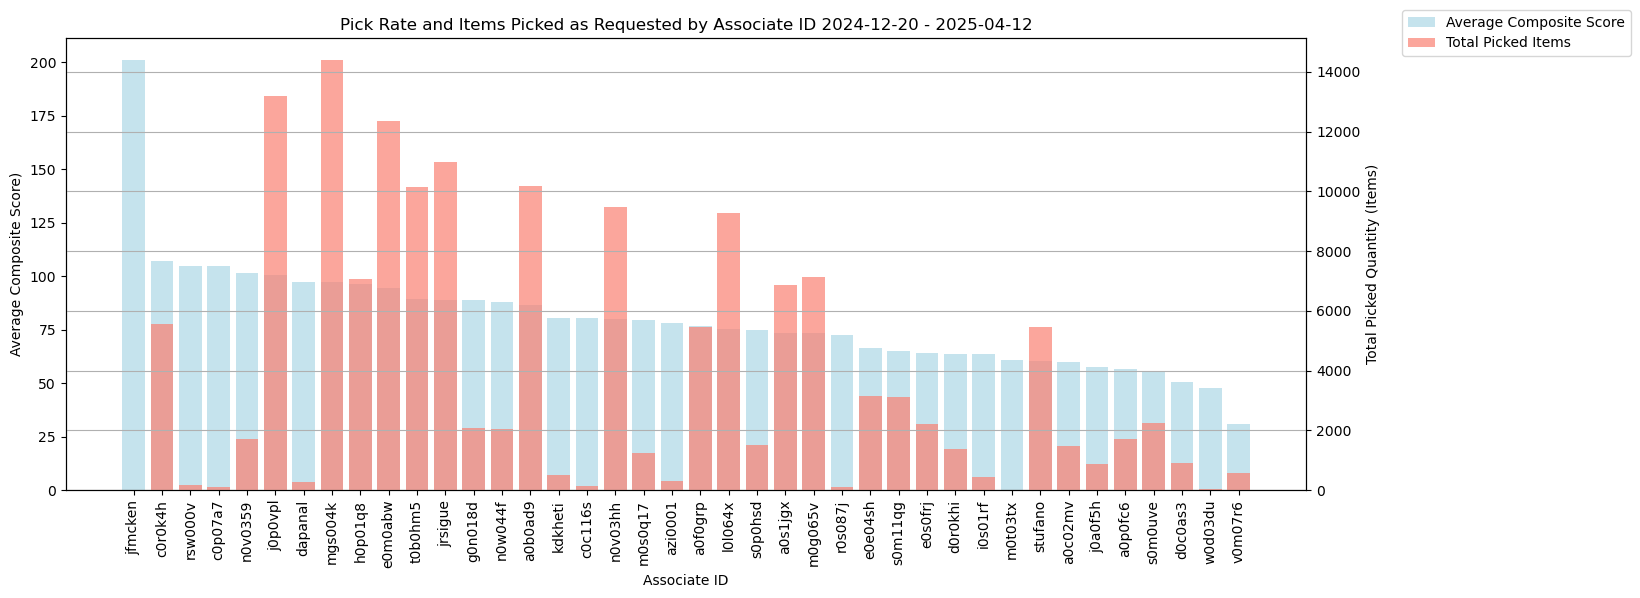

In [65]:

# Plotting side-by-side bar plot for average Composite Score and total Picked As Req Qty
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Composite_Score'] = pd.to_numeric(df['Composite_Score'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df.dropna(subset=['Picked As Req Qty', 'Composite_Score'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_composite_score = df_clean.groupby('Associate ID')['Composite_Score'].mean().sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate ID')['Picked As Req Qty'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(14, 6))

# Convert Associate ID index to string for plotting
avg_composite_score.index = avg_composite_score.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_composite_score.index, avg_composite_score, color='lightblue', alpha=0.7, label='Average Composite Score')
ax1.set_xlabel('Associate ID')
ax1.set_ylabel('Average Composite Score)')
ax1.set_title(f'Pick Rate and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


<h2>Compare Associate Composite Score WTD to Average</h2>

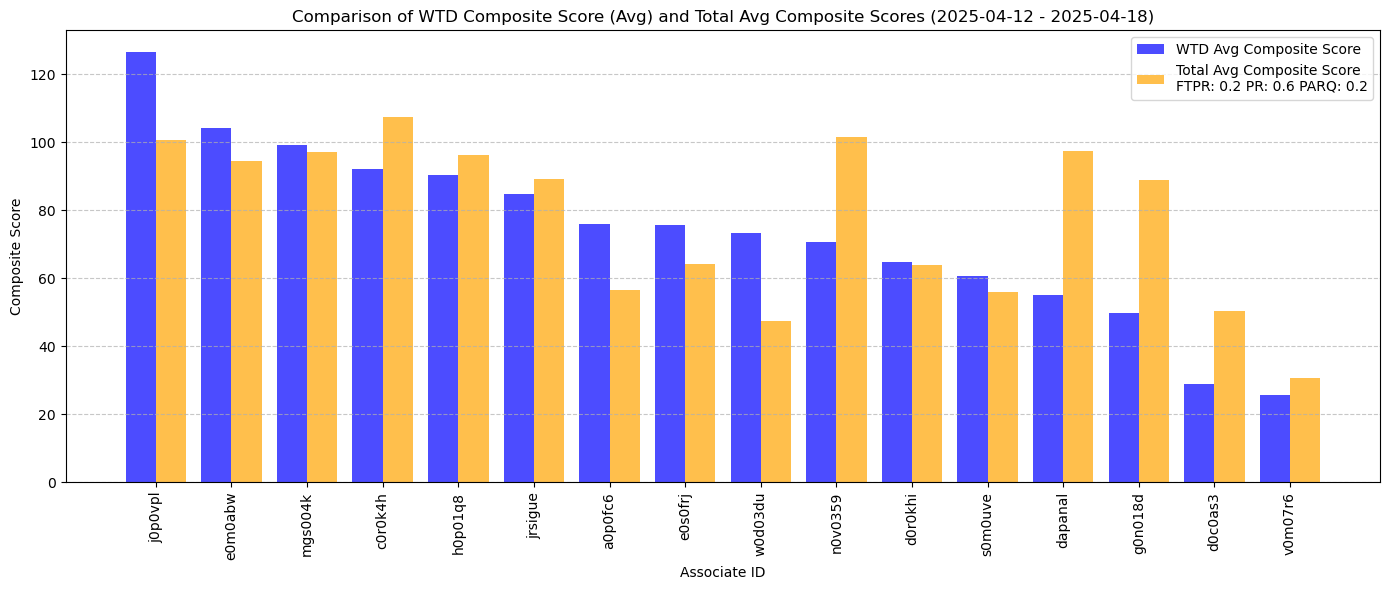

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Define function to find the most recent full week
def get_last_full_week(df):
    """Returns the dataframe filtered for the most recent full week along with the week range."""
    last_full_week_start = df['Custom Week Start'].max()  # Start of the most recent full week
    last_full_week_end = df['Custom Week End'].max()  # End of the most recent full week

    # Filter for the most recent full week
    filtered_df = df[
        (df['Day of Pick Date'] >= last_full_week_start) &
        (df['Day of Pick Date'] <= last_full_week_end)
    ].copy()

    return filtered_df, last_full_week_start, last_full_week_end

# Step 2: Filter data for the most recent full week and get the week range
most_recent_week_data, last_full_week_start, last_full_week_end = get_last_full_week(df_clean)

# Fill NaN values in Composite_Score and filter out associates with a score of 0
most_recent_week_data.loc[:, 'Composite_Score'] = most_recent_week_data['Composite_Score'].fillna(0)
most_recent_week_data = most_recent_week_data[most_recent_week_data['Composite_Score'] > 0]

# Step 3: Calculate last week's and total average Composite Score (only for associates present last week)
last_week_avg_composite_score = (
    most_recent_week_data.groupby(['Associate ID'])['Composite_Score']
    .mean()
)

# Filter df_clean to include only associates who had a score last week
df_clean_filtered = df_clean[df_clean['Associate ID'].isin(last_week_avg_composite_score.index)]

# Compute total average Composite Score (only for associates in last_week_avg_composite_score)
total_avg_composite_score = (
    df_clean_filtered.groupby(['Associate ID'])['Composite_Score']
    .mean()
)

# Step 4: Merge both metrics into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'Last Week Avg Composite Score': last_week_avg_composite_score,
    'Total Avg Composite Score': total_avg_composite_score
})
comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

# Step 5: Plot comparison of last week's and total average Composite Scores
fig, ax = plt.subplots(figsize=(14, 6))

# Create side-by-side bar plot
width = 0.4  # Bar width
x = range(len(comparison_df.index))  # X-axis positions

ax.bar(
    [pos - width / 2 for pos in x],
    comparison_df['Last Week Avg Composite Score'],
    width=width,
    label='WTD Avg Composite Score',
    color='blue',
    alpha=0.7
)
ax.bar(
    [pos + width / 2 for pos in x],
    comparison_df['Total Avg Composite Score'],
    width=width,
    label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}',
    color='orange',
    alpha=0.7
)

# Add labels and title
ax.set_xlabel('Associate ID')
ax.set_ylabel('Composite Score')
ax.set_title(f'Comparison of WTD Composite Score (Avg) and Total Avg Composite Scores ({last_full_week_start.date()} - {last_full_week_end.date()})')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=90)

# Add a legend
ax.legend()

# Display grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<h2></h2>

<h2>Composite Score Comparison LW (full week) to Average</h2>

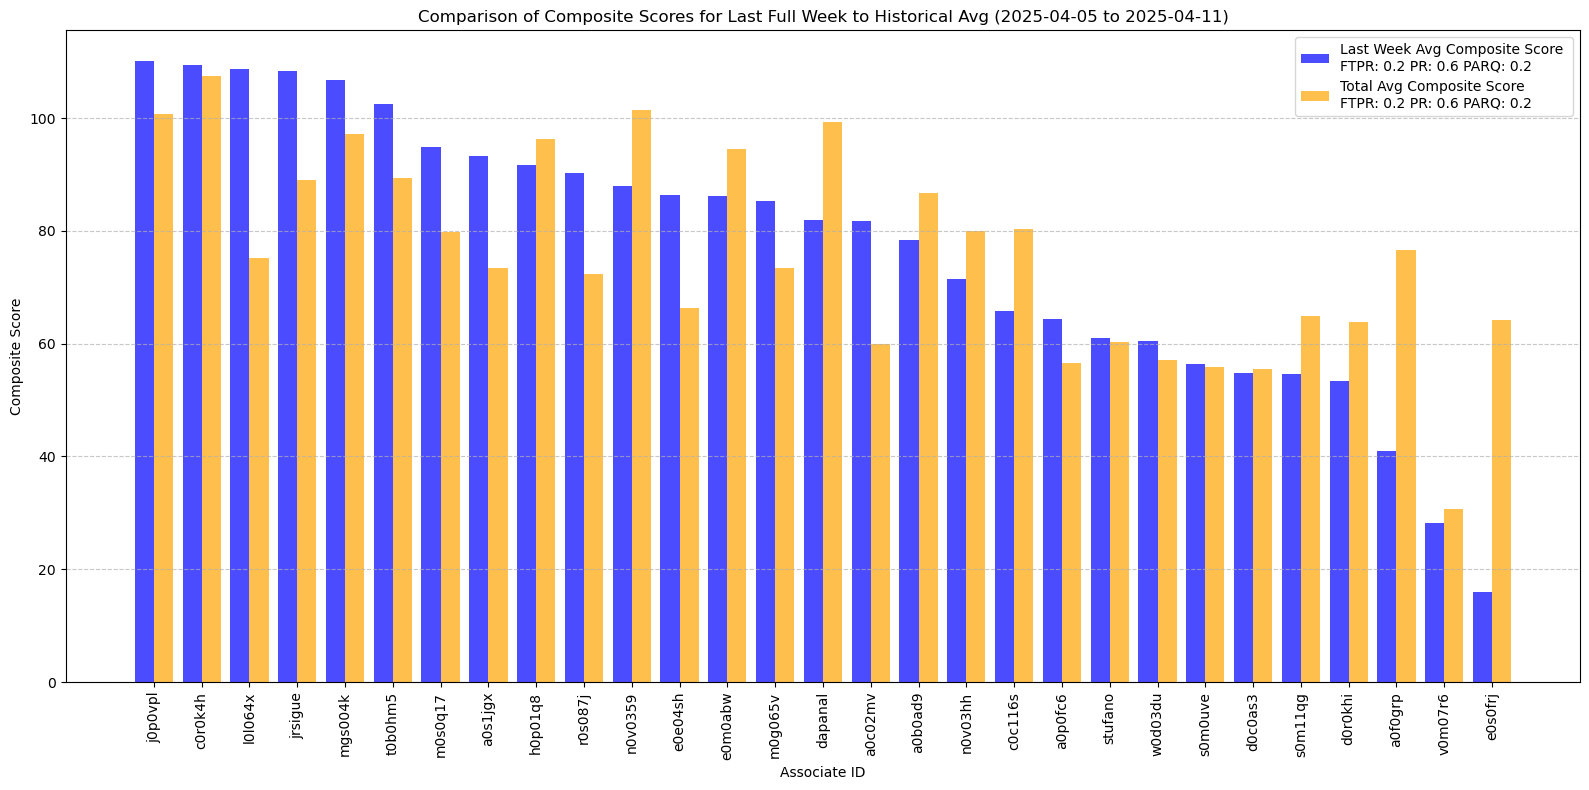

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent full week

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Step 5: Filter associates with Composite_Score > 0
last_week_data = last_week_data[last_week_data['Composite_Score'] > 0]

# Fill NaN values in 'Composite_Score' (if any)
last_week_data['Composite_Score'] = last_week_data['Composite_Score'].fillna(0)

# Step 6: Group by Associate ID and calculate average Composite Score for the last week
avg_composite_score_last_week = (
    last_week_data.groupby('Associate ID')['Composite_Score']
    .mean()
    .sort_values(ascending=False)
)

# Step 7: Filter total average Composite Score to include only IDs in last_week_data
associate_ids_last_week = last_week_data['Associate ID'].unique()  # Get unique Associate IDs from last_week_data
total_avg_composite_score = (
    df[df['Composite_Score'] > 0]
    .groupby('Associate ID')['Composite_Score']
    .mean()
    .loc[associate_ids_last_week]  # Filter to include only Associate IDs from last_week_data
)

# Step 8: Merge both scores into a single DataFrame for proper alignment
comparison_df = pd.DataFrame({
    'Last Week Avg Composite Score': avg_composite_score_last_week,
    'Total Avg Composite Score': total_avg_composite_score
}).fillna(0)

comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

# Step 9: Visualization - Side-by-side bar chart
fig, ax = plt.subplots(figsize=(16, 8))

width = 0.4  # Bar width
x = range(len(comparison_df.index))  # X-axis positions

ax.bar(
    [pos - width / 2 for pos in x], 
    comparison_df['Last Week Avg Composite Score'], 
    width=width, 
    label=f'Last Week Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
    color='blue', 
    alpha=0.7
)

ax.bar(
    [pos + width / 2 for pos in x], 
    comparison_df['Total Avg Composite Score'], 
    width=width, 
    label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
    color='orange', 
    alpha=0.7
)

# Set labels and title
ax.set_xlabel('Associate ID')
ax.set_ylabel(f'Composite Score')
ax.set_title(f'Comparison of Composite Scores for Last Full Week to Historical Avg ({last_full_week})')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=90)

# Add a legend
ax.legend()

# Display grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


<h2>Comparison of Composite Score MTD compared to Last Month</h2>

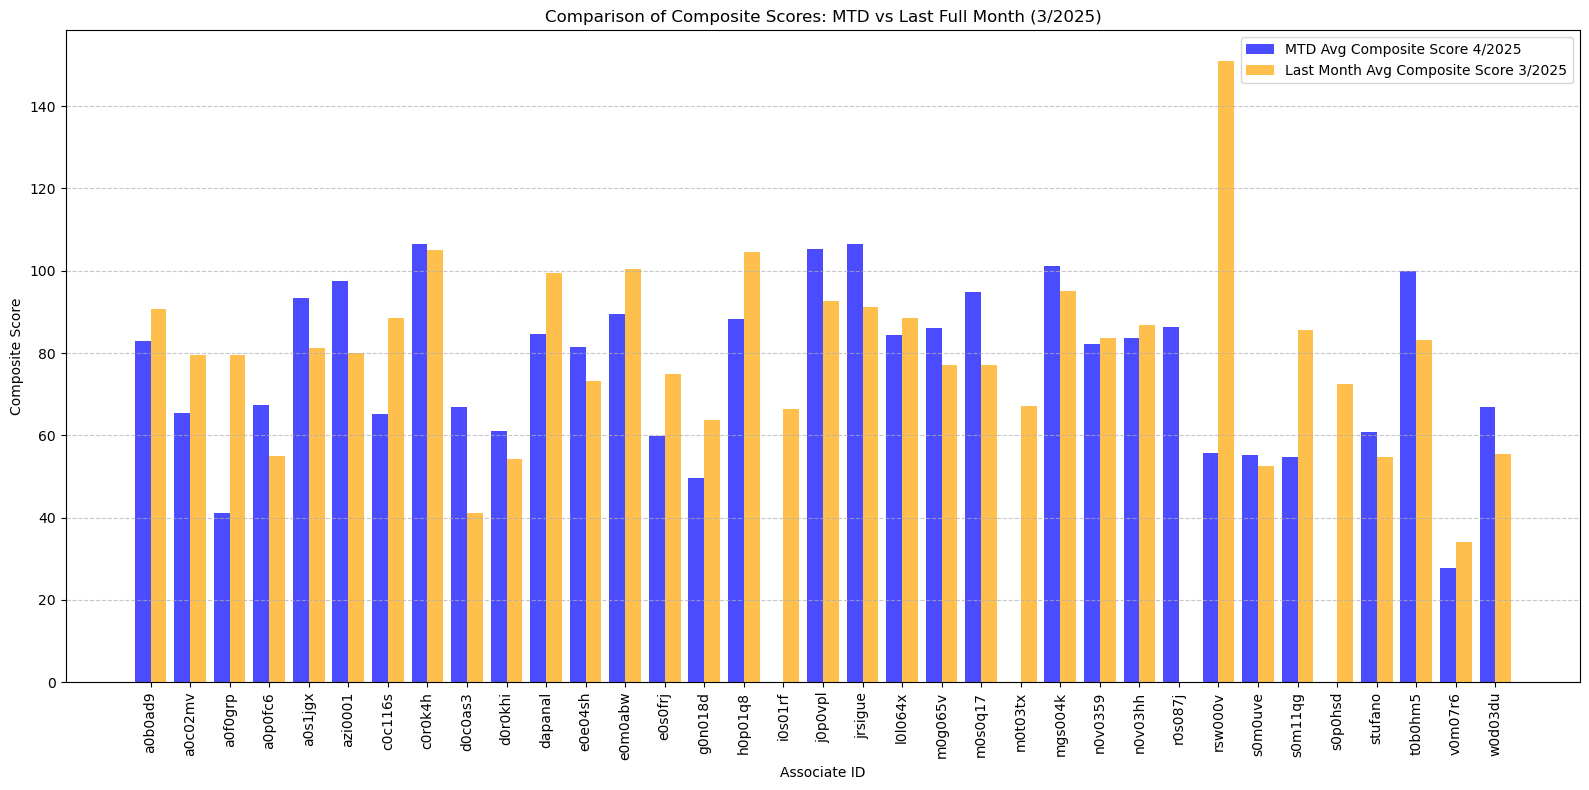

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get the current date and define month-to-date (MTD) and last full month
#today = pd.to_datetime("2025-01-31")
today = pd.to_datetime("today")
current_month = today.month
current_year = today.year

# Define last full month
if current_month == 1:
    last_month = 12
    last_month_year = current_year - 1
else:
    last_month = current_month - 1
    last_month_year = current_year

# Step 2: Filter data for MTD and last full month
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure Date column is in datetime format

# Month-to-Date (MTD) data
mtd_data = df[
    (df['Day of Pick Date'].dt.year == current_year) & 
    (df['Day of Pick Date'].dt.month == current_month) & 
    (df['Composite_Score'] > 0)
]

# Last full month data
last_month_data = df[
    (df['Day of Pick Date'].dt.year == last_month_year) & 
    (df['Day of Pick Date'].dt.month == last_month) & 
    (df['Composite_Score'] > 0)
]

# Step 3: Compute average composite scores for each Associate
avg_composite_score_mtd = mtd_data.groupby('Associate ID')['Composite_Score'].mean()
avg_composite_score_last_month = last_month_data.groupby('Associate ID')['Composite_Score'].mean()

is_empty = mtd_data['Composite_Score'].count() == 0
# Step 4: Merge both scores into a single DataFrame for alignment
comparison_df = pd.DataFrame({
    'MTD Avg Composite Score': avg_composite_score_mtd,
    'Last Month Avg Composite Score': avg_composite_score_last_month
}).fillna(0)

if is_empty == True:
    print(f'No data for {current_month}/{current_year}')
else:
    # Step 5: Visualization - Side-by-side bar chart
    fig, ax = plt.subplots(figsize=(16, 8))
    
    width = 0.4  # Bar width
    x = range(len(comparison_df.index))  # X-axis positions
    
    ax.bar(
        [pos - width / 2 for pos in x], 
        comparison_df['MTD Avg Composite Score'], 
        width=width, 
        label=(f'MTD Avg Composite Score {current_month}/{current_year}'), 
        color='blue', 
        alpha=0.7
    )
    
    ax.bar(
        [pos + width / 2 for pos in x], 
        comparison_df['Last Month Avg Composite Score'], 
        width=width, 
        label=(f'Last Month Avg Composite Score {last_month}/{last_month_year}'), 
        color='orange', 
        alpha=0.7
    )
    
    # Set labels and title
    ax.set_xlabel('Associate ID')
    ax.set_ylabel('Composite Score')
    ax.set_title(f'Comparison of Composite Scores: MTD vs Last Full Month ({last_month}/{last_month_year})')
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df.index, rotation=90)
    
    # Add a legend
    ax.legend()
    
    # Display grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


<h2>Total Performance By Selected Month by Associate</h2>

In [69]:
'''# Extract Year, Month
df['Year'] = df['Day of Pick Date'].dt.year
df['Month'] = df['Day of Pick Date'].dt.month

# Compute the first day of the month for each row
df['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))

# Compute the week number of the first day of the month
df['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week

# Compute the actual week of the month
df['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1

# Define the metrics and their aggregation type
metrics_agg = {
    'FTPR': 'mean',  # Average
    'Pick Rate': 'mean',  
    'Pick Hours': 'mean',  
    'Qty Req to Pick': 'sum',  # Sum
    'Picked As Req Qty': 'sum',
    'Substitution Qty': 'sum',
    'Nil Pick Qty': 'sum',
    'Exception Qty Req to Pick': 'sum'
}

# Group by Associate ID, Year, Month, and Week of Month, applying aggregation functions
weekly_aggregated = df.groupby(['Associate ID', 'Year', 'Month', 'Week of Month'], as_index=False).agg(metrics_agg)

# Filter to ensure no previous month’s data spills over
weekly_aggregated = weekly_aggregated[weekly_aggregated['Week of Month'] > 0]

# Sort for proper plotting
weekly_aggregated = weekly_aggregated.sort_values(by=['Associate ID', 'Year', 'Month', 'Week of Month'])

# Debugging Step: Check if the grouping is correct
print(weekly_aggregated.head(10))  # Print first 10 rows to verify correctness

# Generate individual plots for each Associate
for associate in weekly_aggregated['Associate ID'].unique():
    associate_data = weekly_aggregated[weekly_aggregated['Associate ID'] == associate]

    plt.figure(figsize=(12, 6))

    # Plot each metric as a separate line
    for metric in metrics_agg.keys():
        plt.plot(associate_data['Week of Month'], associate_data[metric], marker='o', linestyle='-', label=metric)

    plt.xlabel('Week of Month')
    plt.ylabel('Value')
    plt.title(f'Weekly Metrics for Associate {associate}')
    plt.legend(loc='best', fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(associate_data['Week of Month'].unique())  # Ensure proper x-axis labels
    plt.tight_layout()
    
    plt.show()
    '''


"# Extract Year, Month\ndf['Year'] = df['Day of Pick Date'].dt.year\ndf['Month'] = df['Day of Pick Date'].dt.month\n\n# Compute the first day of the month for each row\ndf['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))\n\n# Compute the week number of the first day of the month\ndf['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week\n\n# Compute the actual week of the month\ndf['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1\n\n# Define the metrics and their aggregation type\nmetrics_agg = {\n    'FTPR': 'mean',  # Average\n    'Pick Rate': 'mean',  \n    'Pick Hours': 'mean',  \n    'Qty Req to Pick': 'sum',  # Sum\n    'Picked As Req Qty': 'sum',\n    'Substitution Qty': 'sum',\n    'Nil Pick Qty': 'sum',\n    'Exception Qty Req to Pick': 'sum'\n}\n\n# Group by Associate ID, Year, Month, and Week of Month, applying aggregation functions\nweekly_aggregated = df.groupby(['Associate ID',

<h1>disregard the models below for now as of 4/13/2025</h1>

<h2>Using PyTorch (mps) to make a model that predicts FTPR, Pick Rate, Picked As Req Qty</h2>

In [70]:
# Load and preprocess data
# Assuming 'df' is the provided DataFrame
#df = df.copy()
features = ['Pick Hours', 'Qty Req to Pick', 'Substitution Qty', 
            'Nil Pick Qty', 'Exception Qty Req to Pick', 
            'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']
targets = ['FTPR', 'Pick Rate', 'Picked As Req Qty']

X = df[features].values
y = df[targets].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network
class MultiOutputRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiOutputRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = len(features)
output_dim = len(targets)
model = MultiOutputRegression(input_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

    train_mse = mean_squared_error(y_train, y_pred_train.numpy())
    test_mse = mean_squared_error(y_test, y_pred_test.numpy())

    train_r2 = r2_score(y_train, y_pred_train.numpy())
    test_r2 = r2_score(y_test, y_pred_test.numpy())

print("Training Metrics:")
print(f"MSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
print("Testing Metrics:")
print(f"MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")


Epoch [10/100], Loss: 11950.9717
Epoch [20/100], Loss: 11842.2158
Epoch [30/100], Loss: 11644.3057
Epoch [40/100], Loss: 11311.2080
Epoch [50/100], Loss: 10800.6602
Epoch [60/100], Loss: 10079.4199
Epoch [70/100], Loss: 9140.6748
Epoch [80/100], Loss: 8024.8657
Epoch [90/100], Loss: 6831.2148
Epoch [100/100], Loss: 5697.7261
Training Metrics:
MSE: 5592.8205, R2 Score: -13.8626
Testing Metrics:
MSE: 6330.3473, R2 Score: -18.9968


In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

start_time = time.time()
# Define the model architecture with dropout for regularization
class EnhancedMultiOutputRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedMultiOutputRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Assume df is your dataframe and contains the necessary columns
# Features and targets
features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
            'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
            'Exception Substitution Qty', 'Exception Nil Pick Qty']
targets = ['FTPR', 'Pick Rate']

X = df[features].values
y = df[targets].values

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and targets
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, Loss Function, Optimizer
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = EnhancedMultiOutputRegression(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

# Evaluating the model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy()
    y_pred_test = model(X_test_tensor).numpy()

# Reverse scaling to compute metrics
y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

y_train_rescaled = target_scaler.inverse_transform(y_train)
y_test_rescaled = target_scaler.inverse_transform(y_test)

train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

end_time = time.time()
# Print metrics
print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
print(f'Total time: {end_time - start_time}')


Epoch [10/100], Loss: 0.7486
Epoch [20/100], Loss: 0.5982
Epoch [30/100], Loss: 0.5825
Epoch [40/100], Loss: 0.5853
Epoch [50/100], Loss: 0.5556
Epoch [60/100], Loss: 0.5551
Epoch [70/100], Loss: 0.5959
Epoch [80/100], Loss: 0.5964
Epoch [90/100], Loss: 0.5615
Epoch [100/100], Loss: 0.5562
Training Metrics:
MSE: 510.1706, R2 Score: 0.4398
Testing Metrics:
MSE: 148.3571, R2 Score: 0.4887
Total time: 1.8554339408874512


In [72]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'
print(f"Using device: {device}")
#device = 'cpu'
# Define the model architecture with dropout for regularization
class EnhancedMultiOutputRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedMultiOutputRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
        self.fc2 = nn.Linear(128, 256)              # Second hidden layer
        self.fc3 = nn.Linear(256, 128)              # Third hidden layer
        self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
        self.fc5 = nn.Linear(64, output_dim)        # Output layer
        self.relu = nn.ReLU()                       # ReLU activation
        self.dropout = nn.Dropout(0.3)              # Dropout for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))                  # Pass through first layer
        x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
        x = self.relu(self.fc3(x))                  # Pass through third layer
        x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
        x = self.fc5(x)                             # Output layer
        return x

# Features and target columns
features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
            'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
            'Exception Substitution Qty', 'Exception Nil Pick Qty']
targets = ['FTPR', 'Pick Rate']

# Prepare data
X = df[features].values
y = df[targets].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and targets
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

# Convert data to PyTorch tensors and move to the specified device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, Loss Function, Optimizer, and Scheduler
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

# Training the model with validation loss and early stopping
num_epochs = 100
patience, early_stop_counter = 10, 0  # Early stopping patience
best_val_loss = float('inf')

start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    scheduler.step()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pt', weights_only=True))
model.eval()

# Evaluate on training and testing sets
with torch.no_grad():
    y_pred_train = model(X_train_tensor).cpu().numpy()
    y_pred_test = model(X_test_tensor).cpu().numpy()

# Reverse scaling to compute metrics
y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

y_train_rescaled = target_scaler.inverse_transform(y_train)
y_test_rescaled = target_scaler.inverse_transform(y_test)

train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

end_time = time.time()

# Print metrics
print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


Using device: cpu
Epoch [1/100], Train Loss: 0.9097, Val Loss: 0.7034
Epoch [2/100], Train Loss: 0.7801, Val Loss: 0.5314
Epoch [3/100], Train Loss: 0.8358, Val Loss: 0.5359
Epoch [4/100], Train Loss: 0.8291, Val Loss: 0.5452
Epoch [5/100], Train Loss: 0.8065, Val Loss: 0.5430
Epoch [6/100], Train Loss: 0.7713, Val Loss: 0.5244
Epoch [7/100], Train Loss: 0.7627, Val Loss: 0.5400
Epoch [8/100], Train Loss: 0.8307, Val Loss: 0.5104
Epoch [8/100], Train Loss: 0.8307, Val Loss: 0.5104
Epoch [9/100], Train Loss: 0.7955, Val Loss: 0.5069
Epoch [10/100], Train Loss: 0.7915, Val Loss: 0.4483
Epoch [11/100], Train Loss: 0.7984, Val Loss: 0.7401
Epoch [12/100], Train Loss: 0.7017, Val Loss: 0.4818
Epoch [13/100], Train Loss: 0.8058, Val Loss: 0.6627
Epoch [14/100], Train Loss: 0.7555, Val Loss: 0.4312
Epoch [15/100], Train Loss: 0.7173, Val Loss: 0.4175
Epoch [16/100], Train Loss: 0.7776, Val Loss: 0.5207
Epoch [17/100], Train Loss: 0.7329, Val Loss: 0.5040
Epoch [18/100], Train Loss: 0.7093, Va

In [73]:
# Check device
device = torch.device("cpu")
print(f"Using device: {device}")

# Define the model architecture with dropout for regularization
class EnhancedMultiOutputRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedMultiOutputRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
        self.fc2 = nn.Linear(128, 256)              # Second hidden layer
        self.fc3 = nn.Linear(256, 128)              # Third hidden layer
        self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
        self.fc5 = nn.Linear(64, output_dim)        # Output layer
        self.relu = nn.ReLU()                       # ReLU activation
        self.dropout = nn.Dropout(0.3)              # Dropout for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))                  # Pass through first layer
        x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
        x = self.relu(self.fc3(x))                  # Pass through third layer
        x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
        x = self.fc5(x)                             # Output layer
        return x

# Features and target columns
features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
            'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
            'Exception Substitution Qty', 'Exception Nil Pick Qty']
targets = ['FTPR', 'Pick Rate']

# Prepare data
X = df[features].values
y = df[targets].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and targets
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

# Convert data to PyTorch tensors and move to the specified device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, Loss Function, Optimizer, and Scheduler
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

# Training the model with validation loss and early stopping
num_epochs = 100
patience, early_stop_counter = 10, 0  # Early stopping patience
best_val_loss = float('inf')

start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    scheduler.step()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pt', weights_only=True))
model.eval()

# Evaluate on training and testing sets
with torch.no_grad():
    y_pred_train = model(X_train_tensor).cpu().numpy()
    y_pred_test = model(X_test_tensor).cpu().numpy()

# Reverse scaling to compute metrics
y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

y_train_rescaled = target_scaler.inverse_transform(y_train)
y_test_rescaled = target_scaler.inverse_transform(y_test)

train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

end_time = time.time()

# Print metrics
print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


Using device: cpu
Epoch [1/100], Train Loss: 0.9213, Val Loss: 0.7002
Epoch [2/100], Train Loss: 0.9354, Val Loss: 0.5460
Epoch [3/100], Train Loss: 0.8869, Val Loss: 0.6313
Epoch [4/100], Train Loss: 0.8032, Val Loss: 0.5721
Epoch [5/100], Train Loss: 0.7600, Val Loss: 0.4682
Epoch [6/100], Train Loss: 0.7355, Val Loss: 0.7423
Epoch [7/100], Train Loss: 0.8334, Val Loss: 0.6879
Epoch [8/100], Train Loss: 0.7911, Val Loss: 0.5208
Epoch [9/100], Train Loss: 0.7442, Val Loss: 0.3812
Epoch [10/100], Train Loss: 0.7382, Val Loss: 0.5028
Epoch [11/100], Train Loss: 0.8262, Val Loss: 0.4609
Epoch [12/100], Train Loss: 0.7882, Val Loss: 0.4445
Epoch [13/100], Train Loss: 0.7470, Val Loss: 0.5416
Epoch [14/100], Train Loss: 0.7611, Val Loss: 0.3793
Epoch [15/100], Train Loss: 0.7105, Val Loss: 0.4059
Epoch [16/100], Train Loss: 0.7677, Val Loss: 0.5787
Epoch [17/100], Train Loss: 0.7507, Val Loss: 0.5049
Epoch [18/100], Train Loss: 0.6745, Val Loss: 0.4208
Epoch [19/100], Train Loss: 0.7534, V

<h2>Attempt to make PyTorch model better</h2>

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time

# Define Models with More Complexity
class EnhancedModel(nn.Module):
    def __init__(self, input_size):
        super(EnhancedModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Data Preparation (include interaction features or domain-specific knowledge)
df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
df['Total Exceptions'] = (
    df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
    df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
)

X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
        'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
        'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Function with Learning Rate Scheduling
def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
        loss.backward()
        optimizer.step()
        scheduler.step(loss)  # Adjust learning rate based on validation loss
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
    return mse, r2, predictions

# Train and Evaluate Models
start_time = time.time()
input_size = X_train_scaled.shape[1]

# FTPR Model
ftpr_model = EnhancedModel(input_size)
optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
criterion = nn.MSELoss()
ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

# Pick Rate Model
pick_rate_model = EnhancedModel(input_size)
optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

# Picked As Req Qty Model
picked_as_req_qty_model = EnhancedModel(input_size)
optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
    picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
)

end_time = time.time()

# Results
print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
print(f"Total time: {end_time - start_time:.2f} seconds")


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


FTPR Prediction Metrics:
MSE: 125.1118, R2 Score: -0.5419
Pick Rate Prediction Metrics:
MSE: 628.7624, R2 Score: 0.3184
Picked As Req Qty Prediction Metrics:
MSE: 61.4250, R2 Score: 0.9931
Total time: 3.81 seconds


In [75]:
# Feature importance using Random Forest for FTPR
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model on FTPR to find important features
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train_ftpr)
importances = rf.feature_importances_

# Display feature importance
feature_importance = sorted(zip(importances, X.columns), reverse=True)
print("Feature Importance for FTPR:")
for importance, feature in feature_importance:
    print(f"{feature}: {importance:.4f}")

# Select top features based on importance
top_features = [feature for importance, feature in feature_importance if importance > 0.05]
X_train_ftpr = X_train_scaled[:, [X.columns.get_loc(f) for f in top_features]]
X_test_ftpr = X_test_scaled[:, [X.columns.get_loc(f) for f in top_features]]

# Use only these features in the FTPR model
ftpr_model = EnhancedModel(len(top_features))


Feature Importance for FTPR:
Picked As Req Qty: 0.5759
Nil Pick Qty: 0.0944
Pick Hours: 0.0745
Qty Req to Pick: 0.0726
Exception Picked As Req Qty: 0.0547
Substitution Qty: 0.0441
Pick Hours per Qty Req: 0.0226
Exception Qty Req to Pick: 0.0189
Total Exceptions: 0.0171
Exception Nil Pick Qty: 0.0153
Exception Substitution Qty: 0.0098


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time

# Define Models with More Complexity
class EnhancedModel(nn.Module):
    def __init__(self, input_size):
        super(EnhancedModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Data Preparation based on Feature Importance
df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
df['Total Exceptions'] = (
    df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
    df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
)

# Selecting features based on importance
X = df[['Picked As Req Qty', 'Pick Hours per Qty Req', 'Nil Pick Qty', 'Qty Req to Pick', 
        'Substitution Qty', 'Pick Hours', 'Total Exceptions']]  # Focus on important features

y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Function with Learning Rate Scheduling
def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
        loss.backward()
        optimizer.step()
        scheduler.step(loss)  # Adjust learning rate based on validation loss
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
    return mse, r2, predictions

# Train and Evaluate Models
start_time = time.time()
input_size = X_train_scaled.shape[1]

# FTPR Model
ftpr_model = EnhancedModel(input_size)
optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
criterion = nn.MSELoss()
ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

# Pick Rate Model
pick_rate_model = EnhancedModel(input_size)
optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

# Picked As Req Qty Model
picked_as_req_qty_model = EnhancedModel(input_size)
optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
    picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
)

end_time = time.time()

# Results
print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
print(f"Total time: {end_time - start_time:.2f} seconds")

# Feature Importance based on your provided data
# These are the feature importance scores for FTPR as an example
feature_importance = {
    'Picked As Req Qty': 0.2553,
    'Pick Hours per Qty Req': 0.1751,
    'Nil Pick Qty': 0.1545,
    'Qty Req to Pick': 0.1504,
    'Substitution Qty': 0.1096,
    'Pick Hours': 0.0977,
    'Exception Nil Pick Qty': 0.0210,
    'Total Exceptions': 0.0146,
    'Exception Substitution Qty': 0.0128,
    'Exception Qty Req to Pick': 0.0079,
    'Exception Picked As Req Qty': 0.0010
}

print("\nFeature Importance for FTPR:")
for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


FTPR Prediction Metrics:
MSE: 67.9133, R2 Score: 0.1630
Pick Rate Prediction Metrics:
MSE: 266.2113, R2 Score: 0.7114
Picked As Req Qty Prediction Metrics:
MSE: 31.0472, R2 Score: 0.9965
Total time: 3.72 seconds

Feature Importance for FTPR:
Picked As Req Qty: 0.2553
Pick Hours per Qty Req: 0.1751
Nil Pick Qty: 0.1545
Qty Req to Pick: 0.1504
Substitution Qty: 0.1096
Pick Hours: 0.0977
Exception Nil Pick Qty: 0.0210
Total Exceptions: 0.0146
Exception Substitution Qty: 0.0128
Exception Qty Req to Pick: 0.0079
Exception Picked As Req Qty: 0.0010


FTPR Model Evaluation:
MSE: 110.59430480536712
R2 Score: -0.36297084596710727
Pick Rate Model Evaluation:
MSE: 892.3387593433588
R2 Score: 0.032629555163000035


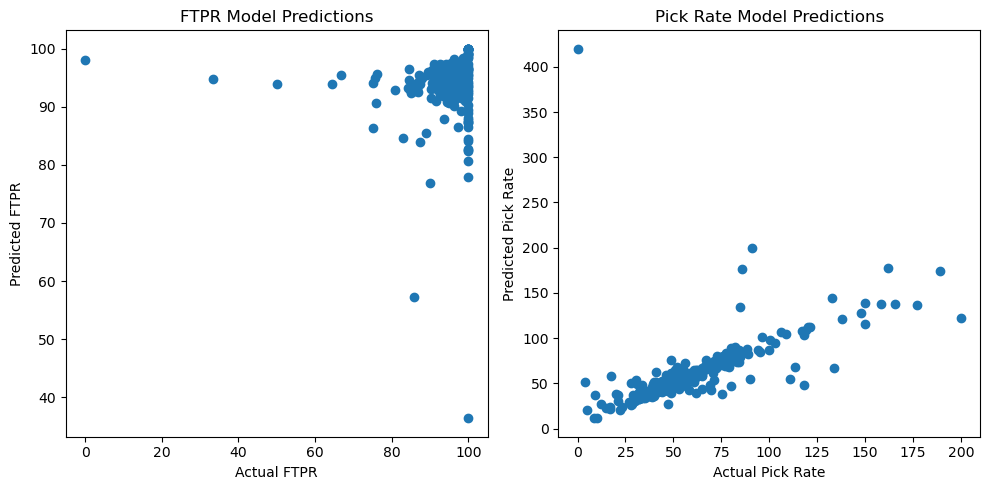

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Data Preprocessing
X = df[['Day of Pick Date', 'Qty Req to Pick', 'Pick Hours']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']

# Convert date column to datetime format and extract day, month, year features
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
df['day_of_month'] = df['Day of Pick Date'].dt.day
df['month'] = df['Day of Pick Date'].dt.month

X = df[['Qty Req to Pick', 'Pick Hours', 'day_of_month', 'month']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']

# Split data into training and testing sets
X_train, X_test, y_ftpr_train, y_ftpr_test = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_pick_rate_train, y_pick_rate_test = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
model_ftpr = RandomForestRegressor(n_estimators=100)
model_ftpr.fit(X_train_scaled, y_ftpr_train)

y_ftpr_pred = model_ftpr.predict(X_test_scaled)
print("FTPR Model Evaluation:")
print(f"MSE: {mean_squared_error(y_ftpr_test, y_ftpr_pred)}")
print(f"R2 Score: {r2_score(y_ftpr_test, y_ftpr_pred)}")

model_pick_rate = RandomForestRegressor(n_estimators=100)
model_pick_rate.fit(X_train_scaled, y_pick_rate_train)

y_pick_rate_pred = model_pick_rate.predict(X_test_scaled)
print("Pick Rate Model Evaluation:")
print(f"MSE: {mean_squared_error(y_pick_rate_test, y_pick_rate_pred)}")
print(f"R2 Score: {r2_score(y_pick_rate_test, y_pick_rate_pred)}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_ftpr_test, y_ftpr_pred)
plt.xlabel("Actual FTPR")
plt.ylabel("Predicted FTPR")
plt.title("FTPR Model Predictions")

plt.subplot(1, 2, 2)
plt.scatter(y_pick_rate_test, y_pick_rate_pred)
plt.xlabel("Actual Pick Rate")
plt.ylabel("Predicted Pick Rate")
plt.title("Pick Rate Model Predictions")

plt.tight_layout()
plt.show()


<h2>Attempt to try different models to improve accuracy</h2>

In [78]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for FTPR and Pick Rate models
ftpr_param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20]
}

pick_rate_param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20]
}

# Perform grid search for FTPR model
ftpr_gs = GridSearchCV(RandomForestRegressor(), ftpr_param_grid, cv=5)
ftpr_gs.fit(X_train_scaled, y_ftpr_train)

print("FTPR Model Best Parameters:", ftpr_gs.best_params_)
print("FTPR Model Best Score:", ftpr_gs.best_score_)

# Perform grid search for Pick Rate model
pick_rate_gs = GridSearchCV(RandomForestRegressor(), pick_rate_param_grid, cv=5)
pick_rate_gs.fit(X_train_scaled, y_pick_rate_train)

print("Pick Rate Model Best Parameters:", pick_rate_gs.best_params_)
print("Pick Rate Model Best Score:", pick_rate_gs.best_score_)

# Train models with best parameters and evaluate
ftpr_best_model = ftpr_gs.best_estimator_
pick_rate_best_model = pick_rate_gs.best_estimator_

y_ftpr_pred = ftpr_best_model.predict(X_test_scaled)
y_pick_rate_pred = pick_rate_best_model.predict(X_test_scaled)

print("FTPR Model Evaluation (Best Parameters):")
print("MSE:", mean_squared_error(y_ftpr_test, y_ftpr_pred))
print("R2 Score:", r2_score(y_ftpr_test, y_ftpr_pred))

print("Pick Rate Model Evaluation (Best Parameters):")
print("MSE:", mean_squared_error(y_pick_rate_test, y_pick_rate_pred))
print("R2 Score:", r2_score(y_pick_rate_test, y_pick_rate_pred))

FTPR Model Best Parameters: {'max_depth': 5, 'n_estimators': 50}
FTPR Model Best Score: 0.015696871387413668
Pick Rate Model Best Parameters: {'max_depth': 15, 'n_estimators': 100}
Pick Rate Model Best Score: 0.5610083078128076
FTPR Model Evaluation (Best Parameters):
MSE: 90.99205377649685
R2 Score: -0.12139152852668222
Pick Rate Model Evaluation (Best Parameters):
MSE: 842.2848609702963
R2 Score: 0.08689220085442606


In [79]:
df.head()

,Associate ID,Associate Name,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,...,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty,Day of Week,Week of Year,Is Weekend,Pick Hours per Qty Req,Total Exceptions,day_of_month,month
2559,e0e04sh,Erik Enriquez,2024-12-20,100.00,5,0,16.0,0.32,5,0.0,...,91.212000,16.203583,5.00,4,51,0,0.064000,0.0,20,12
2761,n0v0359,Nathaniel Ventura,2024-12-20,89.78,139,0,56.0,2.31,126,3.0,...,96.321052,56.367582,126.02,4,51,0,0.016619,0.0,20,12
2815,s0m11qg,Shubhada Mengle,2024-12-20,89.26,129,0,30.0,3.88,108,9.0,...,89.822000,30.458699,108.16,4,51,0,0.030078,0.0,20,12
2689,l0l064x,Lucille Lawson,2024-12-20,96.06,205,0,39.0,5.09,195,2.0,...,96.152334,40.428063,195.04,4,51,0,0.024829,2.0,20,12
2647,j0p0vpl,Jesica Pugo,2024-12-20,94.17,244,0,66.0,3.63,236,2.0,...,95.852542,66.500079,235.94,4,51,0,0.014877,0.0,20,12


In [80]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Data Preparation
df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
df['Total Exceptions'] = (
    df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
    df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
)

X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
        'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
        'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
y_ftpr = df['FTPR']
y_pick_rate = df['Pick Rate']
y_picked_as_req_qty = df['Picked As Req Qty']

# Train-Test Split
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
_, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training for FTPR
ftpr_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
ftpr_model.fit(X_train_scaled, y_train_ftpr)

# Model Training for Pick Rate
pick_rate_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
pick_rate_model.fit(X_train_scaled, y_train_pick_rate)

# Model Training for Picked As Req Qty
picked_as_req_qty_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
picked_as_req_qty_model.fit(X_train_scaled, y_train_picked_as_req_qty)

# Predictions
ftpr_preds = ftpr_model.predict(X_test_scaled)
pick_rate_preds = pick_rate_model.predict(X_test_scaled)
picked_as_req_qty_preds = picked_as_req_qty_model.predict(X_test_scaled)

# Evaluation
print("FTPR Metrics")
print(f"MSE: {mean_squared_error(y_test_ftpr, ftpr_preds):.4f}")
print(f"R2: {r2_score(y_test_ftpr, ftpr_preds):.4f}")

print("\nPick Rate Metrics")
print(f"MSE: {mean_squared_error(y_test_pick_rate, pick_rate_preds):.4f}")
print(f"R2: {r2_score(y_test_pick_rate, pick_rate_preds):.4f}")

print("\nPicked As Req Qty Metrics")
print(f"MSE: {mean_squared_error(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")
print(f"R2: {r2_score(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")


FTPR Metrics
MSE: 36.6618
R2: 0.5482

Pick Rate Metrics
MSE: 65.4312
R2: 0.9291

Picked As Req Qty Metrics
MSE: 14.5523
R2: 0.9984


In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ===========================================
# Load and Preprocess Data
# ===========================================

# Example DataFrame (replace with actual data loading)
# df = pd.read_csv('your_dataset.csv')

# Convert 'Day of Pick Date' and other datetime columns to numeric features (e.g., day of the week)
if "Day of Pick Date" in df.columns:
    df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
    df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
    df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month

# Drop irrelevant columns
X = df.drop(columns=[
    "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
    "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
    "Composite_Score", "Associate ID"
])

# Target variables
y_ftpr = df["FTPR"]
y_pick_rate = df["Pick Rate"]

# Convert categorical features to numeric using one-hot encoding
X_numeric = pd.get_dummies(X, drop_first=True)

# Ensure all columns are numeric
X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)

# Split data into training and testing sets
X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X_numeric, y_ftpr, test_size=0.2, random_state=42)
_, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X_numeric, y_pick_rate, test_size=0.2, random_state=42)

# Scale numeric features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===========================================
# Train and Evaluate Models
# ===========================================

# Define a function to train and evaluate models
def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"{label} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    return model

# Train Random Forest Regressor for FTPR
ftpr_model = RandomForestRegressor(n_estimators=500, random_state=42)
ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

# Train Random Forest Regressor for Pick Rate
pick_rate_model = RandomForestRegressor(n_estimators=500, random_state=42)
pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

# ===========================================
# Notes
# ===========================================
# - Handled datetime columns by extracting numeric features.
# - Dropped irrelevant columns to avoid data leakage.
# - Converted categorical features to numeric using `pd.get_dummies`.
# - Ensured all columns are numeric with `pd.to_numeric` and replaced NaN values with 0.
# - Scaled features using `StandardScaler` for improved model performance.


FTPR Metrics:
MSE: 34.9719
R2: 0.5690
Pick Rate Metrics:
MSE: 273.1606
R2: 0.7039


In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define constants
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_ESTIMATORS = 500

def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print("File not found.")
        return None

def preprocess_data(df):
    if "Day of Pick Date" in df.columns:
        df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
        df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
        df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
    
    X = df.drop(columns=[
        "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
        "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
        "Composite_Score", "Associate ID"
    ])
    
    y_ftpr = df["FTPR"]
    y_pick_rate = df["Pick Rate"]
    
    X_numeric = pd.get_dummies(X, drop_first=True)
    X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
    
    return X_numeric, y_ftpr, y_pick_rate

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    print(f"{label} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return model

# Preprocess data
X, y_ftpr, y_pick_rate = preprocess_data(df)

# Split data
X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
_, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

FTPR Metrics:
MSE: 34.9719
R2: 0.5690
MAE: 2.9158
Pick Rate Metrics:
MSE: 273.1606
R2: 0.7039
MAE: 6.0280


In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define constants
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_ESTIMATORS = 500

def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print("File not found.")
        return None

def preprocess_data(df):
    if "Day of Pick Date" in df.columns:
        df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
        df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
        df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
    
    X = df.drop(columns=[
        "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
        "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
        "Composite_Score", "Associate ID"
    ])
    
    y_ftpr = df["FTPR"]
    y_pick_rate = df["Pick Rate"]
    
    X_numeric = pd.get_dummies(X, drop_first=True)
    X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
    
    return X_numeric, y_ftpr, y_pick_rate

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    print(f"{label} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return model


# Preprocess data
X, y_ftpr, y_pick_rate = preprocess_data(df)

# Split data
X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
_, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

FTPR Metrics:
MSE: 34.9719
R2: 0.5690
MAE: 2.9158
Pick Rate Metrics:
MSE: 273.1606
R2: 0.7039
MAE: 6.0280


In [84]:
combine_data_to_csv()

Directory 'Data/Comnined/' already exists.
